# 3.2.1 정상성

### 정상성 vs. 비정상성

#### 모듈과 데이터 불러오기

In [1]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

#데이터 불러오기
ticker = "AAPL"
start_date = "2024-01-01"
end_date = "2024-12-31"
stock = yf.download(ticker, start=start_date, end=end_date)
stock = stock[['Close']]

pig = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/aus_livestock.csv')
pig = pig[(pig['Animal'] == 'Pigs') & (pig['State'] == 'Victoria')]
pig.index = pd.to_datetime(pig['Month'], format='%Y %m')

pelt = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/pelt.csv')
pelt.index = pd.to_datetime(pelt['Year'], format='%Y')

aus_prod = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/aus_production.csv')
aus_prod.index = pd.date_range(start='1956/01/01', periods=218, freq='3MS')

[*********************100%***********************]  1 of 1 completed


#### 정상성 비교 시각화

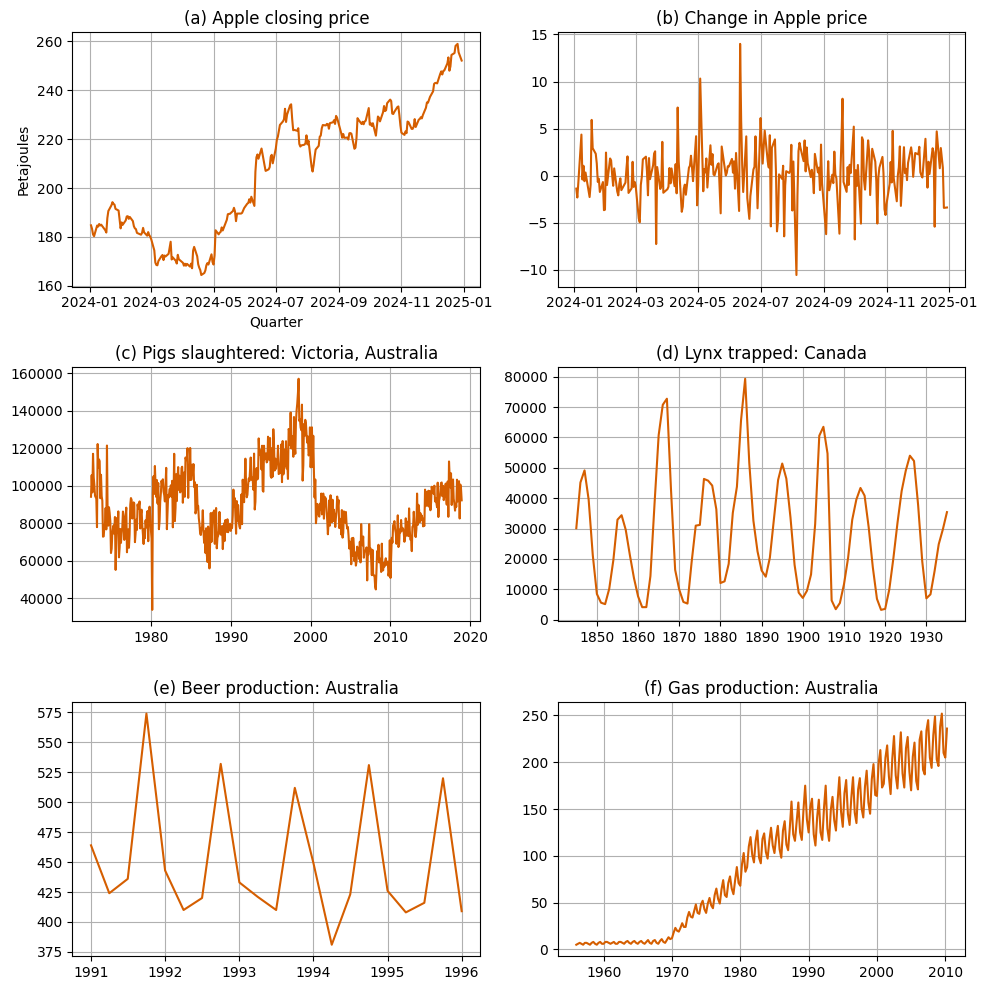

In [3]:
#6개 시계열 시각화
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=False)

axes[0, 0].plot(stock['Close'], color='#D55E00')
axes[0, 0].set_title('(a) Apple closing price')
axes[0, 0].set_ylabel("$US")
axes[0, 0].set_xlabel('Day')

axes[0, 1].plot(stock['Close'].diff(), color='#D55E00')
axes[0, 1].set_title('(b) Change in Apple price')
axes[0, 0].set_ylabel("$US")
axes[0, 0].set_xlabel('Day')

axes[1, 0].plot(pig['Count'], color='#D55E00')
axes[1, 0].set_title('(c) Pigs slaughtered: Victoria, Australia')
axes[0, 0].set_ylabel("Number of pigs")
axes[0, 0].set_xlabel('Month')

axes[1, 1].plot(pelt['Lynx'], color='#D55E00')
axes[1, 1].set_title('(d) Lynx trapped: Canada')
axes[0, 0].set_ylabel("Number of lynx")
axes[0, 0].set_xlabel('Year')

axes[2, 0].plot(aus_prod['Beer'].loc['1991-01-01':'1996-01-01'], color='#D55E00')
axes[2, 0].set_title('(e) Beer production: Australia')
axes[0, 0].set_ylabel("Megalitres")
axes[0, 0].set_xlabel('Quarter')

axes[2, 1].plot(aus_prod['Gas'], color='#D55E00')
axes[2, 1].set_title('(f) Gas production: Australia')
axes[0, 0].set_ylabel("Petajoules")
axes[0, 0].set_xlabel('Quarter')

for i in range(3):
    for j in range(2):
        axes[i, j].grid(True)

plt.tight_layout()
plt.show()

# 3.2.2 랜덤 워크와 차분

## 1. 차분

### 코르티코스테로이드 판매량 그래프

#### 모듈과 데이터 불러오기

In [3]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#데이터 불러오기
h02 = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/h02.csv", index_col=0)
h02.index = pd.date_range(start='1/1/1992', periods=h02.shape[0], freq='1MS')

h02

,x
1992-01-01,0.429795
1992-02-01,0.400906
1992-03-01,0.432159
1992-04-01,0.492543
1992-05-01,0.502369
...,...
2008-08-01,0.761822
2008-09-01,0.649435
2008-10-01,0.827887
2008-11-01,0.816255


#### 전처리와 시각화

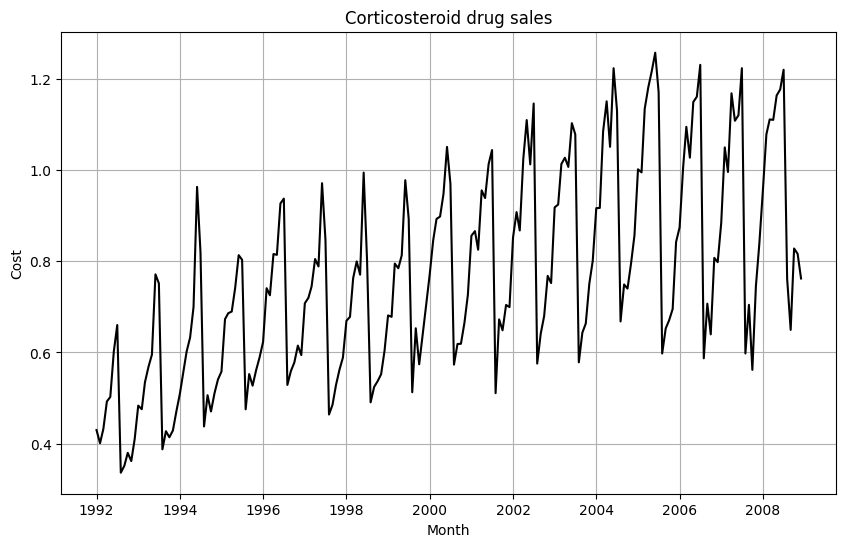

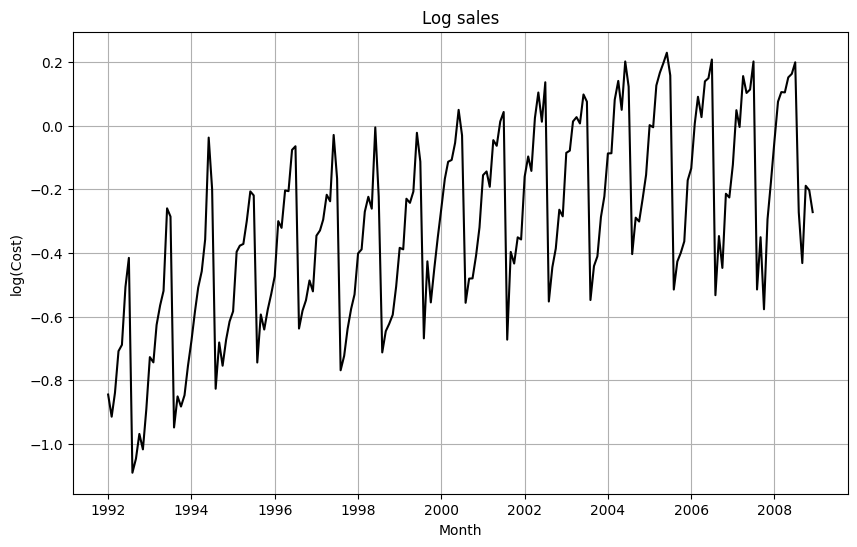

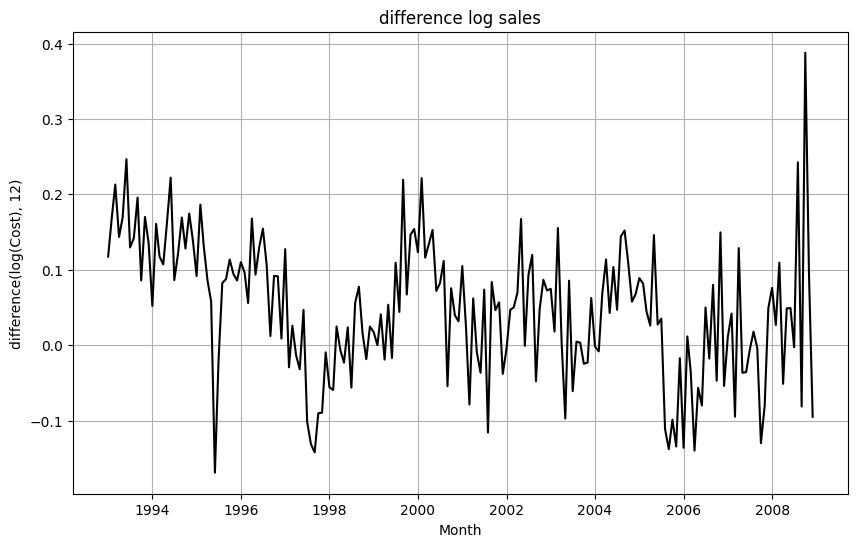

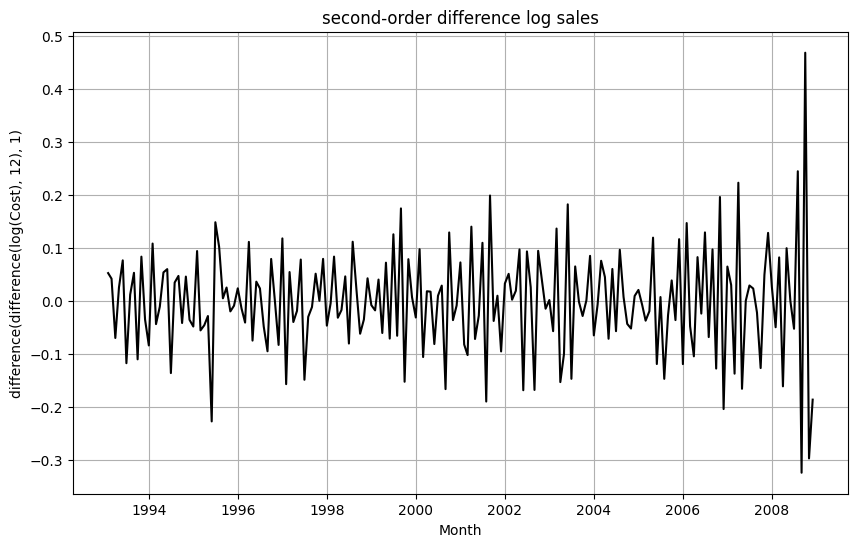

In [4]:
#필요한 함수 정의
def log_series(series):
    tmp = np.log(series)
    return pd.Series(tmp, series.index)

def plot_series(series, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(series,  color='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

#데이터 시각화
plot_series(h02.x, "Month", "Cost", "Corticosteroid drug sales")

log_h02 = log_series(h02.x)
plot_series(log_h02, "Month", "log(Cost)", "Log sales")

diff12_h02 = log_h02.diff(12)[12:]
plot_series(diff12_h02, "Month", "difference(log(Cost), 12)", "difference log sales")

diff1_diff12_h02 = diff12_h02.diff()[1:]
plot_series(diff1_diff12_h02, "Month", "difference(difference(log(Cost), 12), 1)", "second-order difference log sales")

## 2. 차분 자동 선택

In [5]:
from statsmodels.tsa.seasonal import STL

def seasonal_strength(series):
    stl_result = STL(series).fit()
    r = stl_result.resid
    s = stl_result.seasonal
    var1 = r.var()
    var2 = (s+r).var()
    return max(0, 1-var1/var2)

print(seasonal_strength(log_h02))
print(seasonal_strength(diff12_h02))

0.9708953840295775
0.25648096270088416


# 3.2.3 자기회귀(AR)

## 1. AR(1) 예시

#### 모듈 불러오기

In [5]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### 데이터 생성 및 시각화

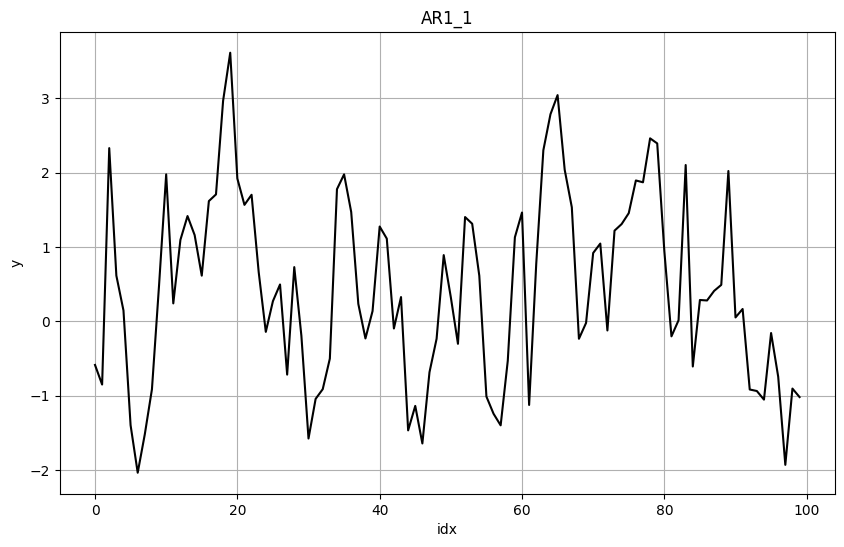

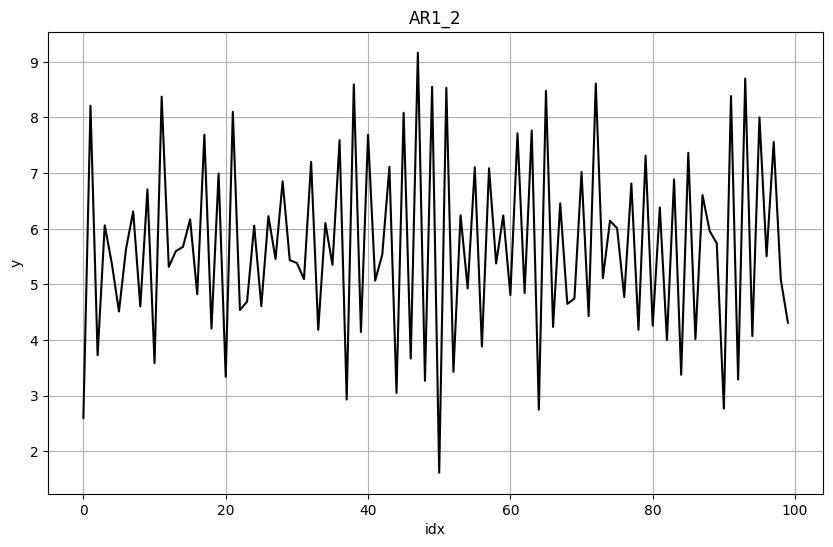

In [6]:
#시각화 함수 정의
def plot_series(series, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(series,  color='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

#예시 생성 함수
def AR1(c=0, phi=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c/(1 - phi) + noise[0]]
    for i in range(1, n):
        data.append(c + phi * data[i-1] + noise[i])
    return data

#시각화
ex_AR1_1 = pd.Series(AR1(phi=0.75))
plot_series(ex_AR1_1, "idx", "y", "AR1_1")

ex_AR1_2 = pd.Series(AR1(c=10, phi=-0.75))
plot_series(ex_AR1_2, "idx", "y", "AR1_2")

#### ACF 시각화

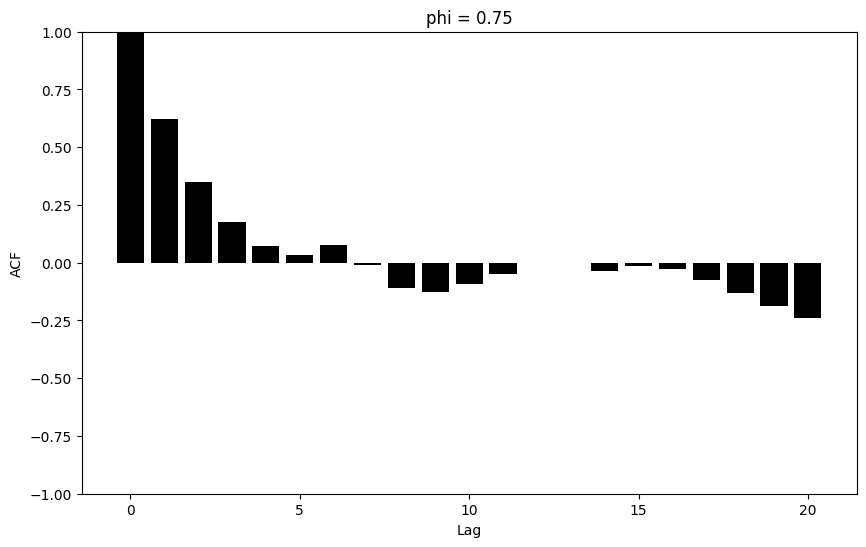

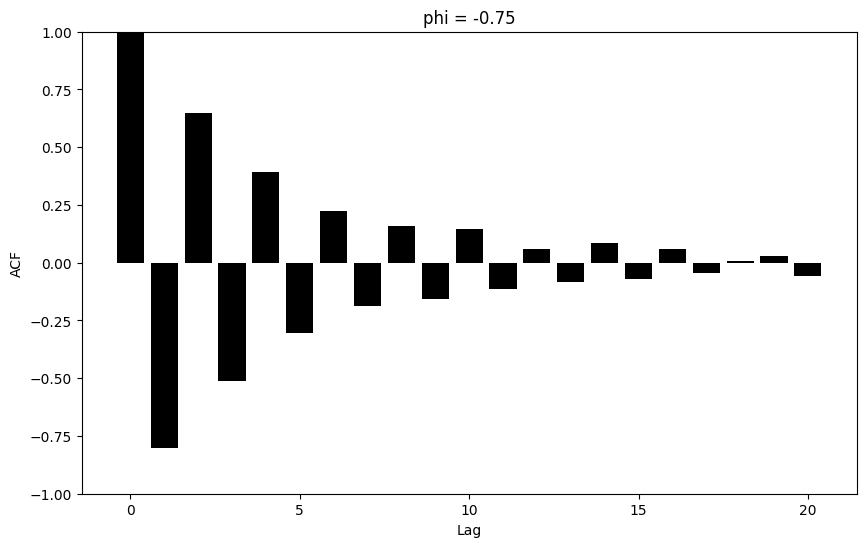

In [7]:
#ACF 시각화 함수
def show_ACF(series, title, start=0, nlags=None):
    plt.figure(figsize=(10, 6))
    ACF = acf(series, fft=False, nlags=nlags)
    plt.bar(range(start, ACF.shape[0]), ACF[start:], color='black')
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.ylim(-1, 1)
    plt.title(title)
    plt.show()

#수동 시각화
show_ACF(ex_AR1_1, "phi = 0.75")
show_ACF(ex_AR1_2, "phi = -0.75")

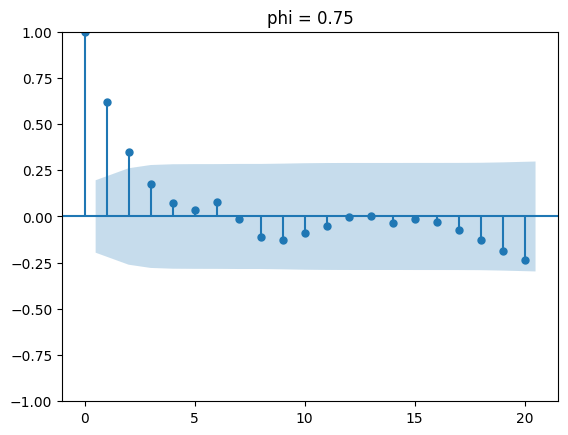

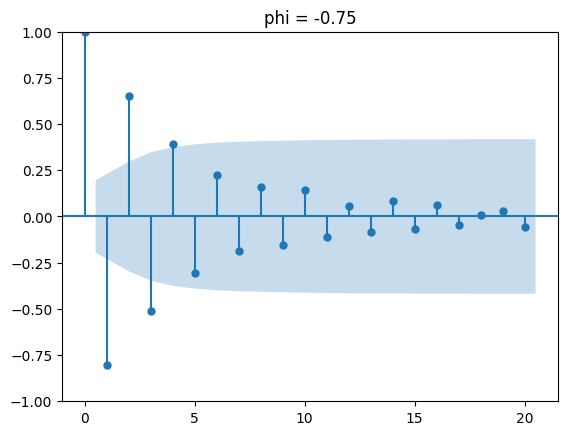

In [8]:
#모듈을 통한 시각화
plot_acf(ex_AR1_1)
plt.title('phi = 0.75')
plt.show()

plot_acf(ex_AR1_2)
plt.title('phi = -0.75')
plt.show()

## 2. AR(p) 예시

#### 데이터 생성 및 시각화

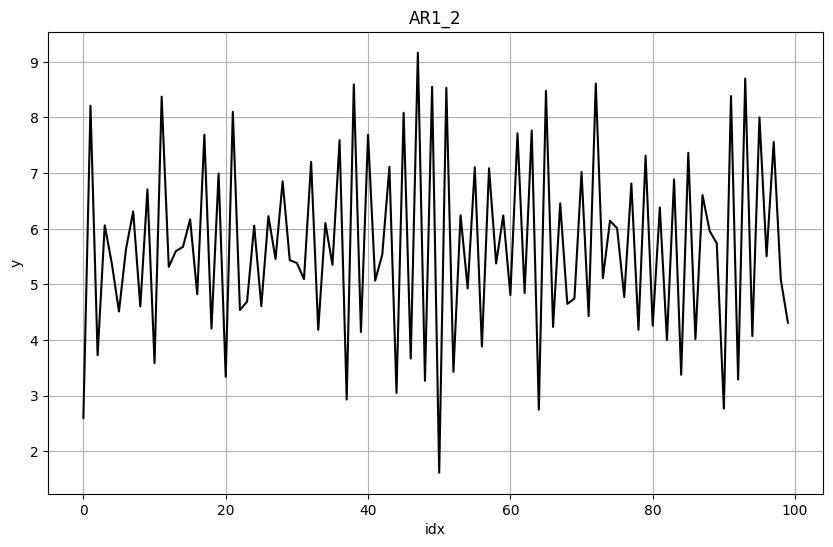

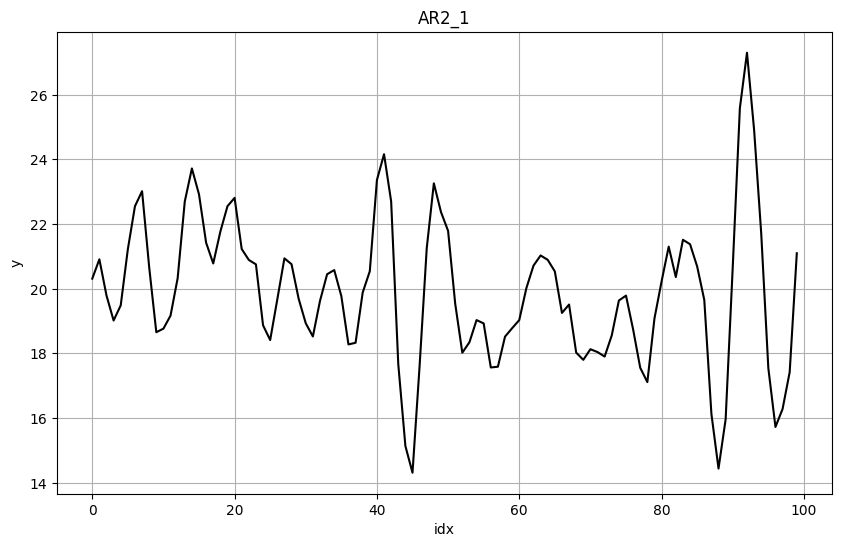

In [9]:
#예시 생성 함수
def AR2(c=0, phi1=0, phi2=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c/(1 - phi1 - phi2) + noise[0], c/(1 - phi1 - phi2) + noise[1]]
    for i in range(2, n):
        data.append(c + phi1 * data[i-1] + phi2 * data[i-2] + noise[i])
    return data

#시각화
plot_series(ex_AR1_2, "idx", "y", "AR1_2")

ex_AR2_1 = pd.Series(AR2(c=10, phi1=1.25, phi2=-0.75))
plot_series(ex_AR2_1, "idx", "y", "AR2_1")

#### ACF 시각화

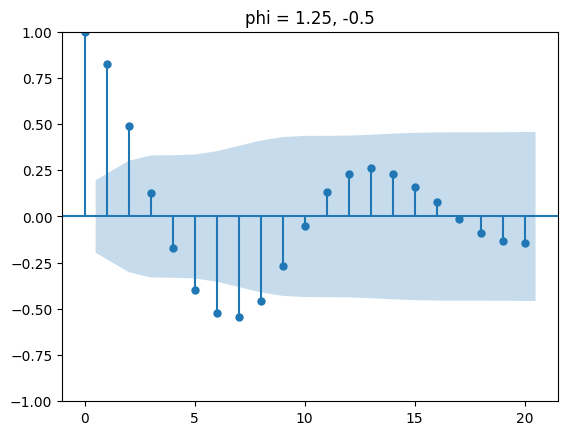

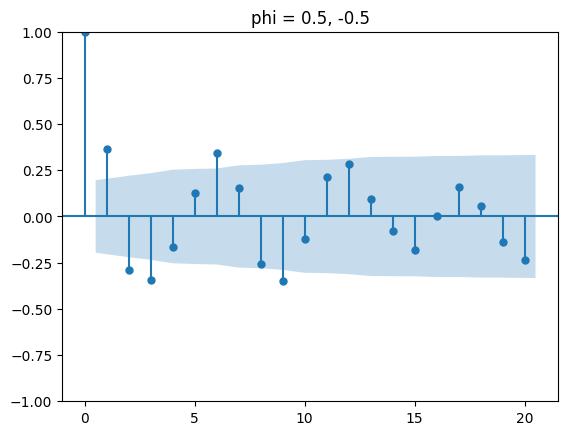

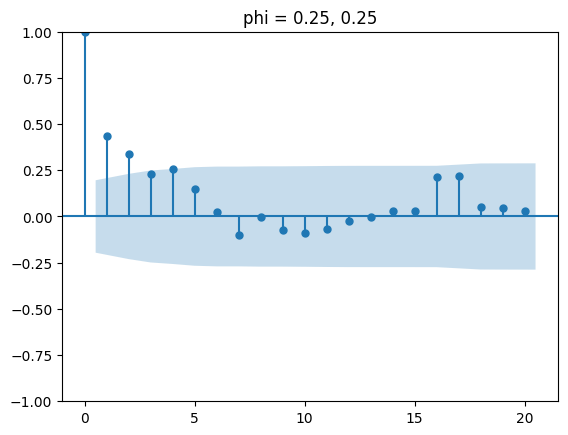

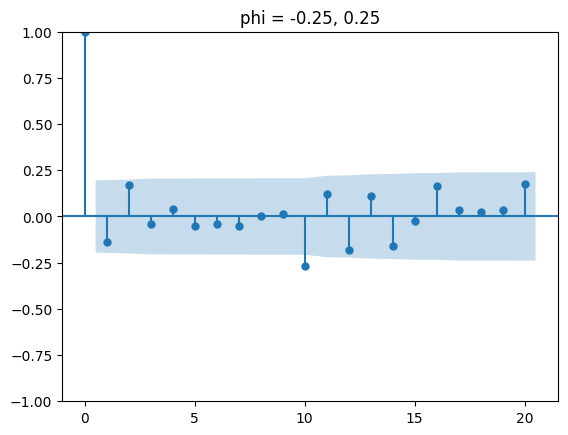

In [10]:
#예시 생성
ex_AR2_2 = pd.Series(AR2(phi1=1.25, phi2=-0.5))
ex_AR2_3 = pd.Series(AR2(phi1=0.5, phi2=-0.5))
ex_AR2_4 = pd.Series(AR2(phi1=0.25, phi2=0.25))
ex_AR2_5 = pd.Series(AR2(phi1=-0.25, phi2=0.25))

#ACF 자동 생성
plot_acf(ex_AR2_2)
plt.title('phi = 1.25, -0.5')
plt.show()

plot_acf(ex_AR2_3)
plt.title('phi = 0.5, -0.5')
plt.show()

plot_acf(ex_AR2_4)
plt.title('phi = 0.25, 0.25')
plt.show()

plot_acf(ex_AR2_5)
plt.title('phi = -0.25, 0.25')
plt.show()

## 3. 부분 자기상관 함수(PACF)

#### 데이터 생성 및 시각화

In [17]:
#예시 생성
noise = np.random.normal(0, 1, 100)
data = [noise[0]]
for i in range(1, 100):
    data.append(0.25 * data[i-1] + noise[i])
ex_AR3_1 = pd.Series(data)

data = [noise[0]]
for i in range(1, 100):
    data.append(0.99 * data[i-1] + noise[i])
ex_AR3_2 = pd.Series(data)

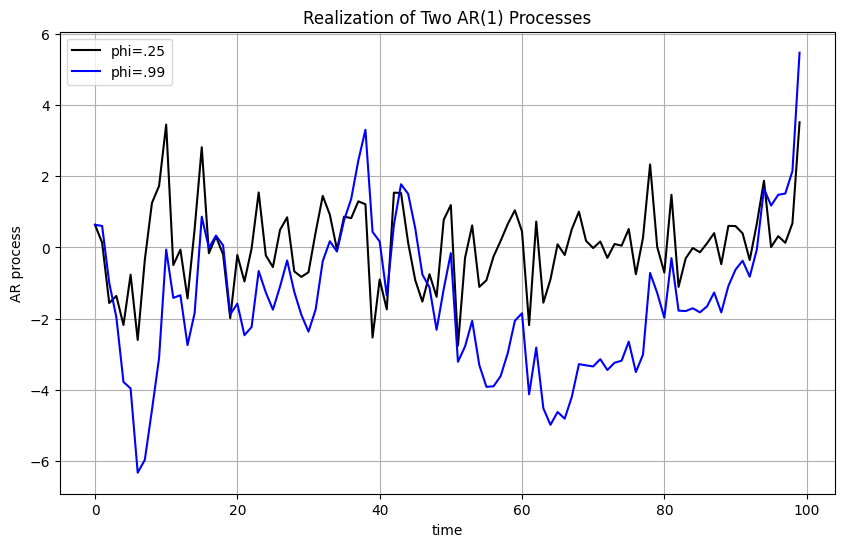

In [19]:
#시각화
plt.figure(figsize=(10, 6))
plt.plot(ex_AR3_1,  color='black', label='phi=.25')
plt.plot(ex_AR3_2,  color='b', label='phi=.99')
plt.xlabel("time")
plt.ylabel("AR process")
plt.title("Realization of Two AR(1) Processes")
plt.grid(True)
plt.legend()
plt.show()

#### ACF 시각화

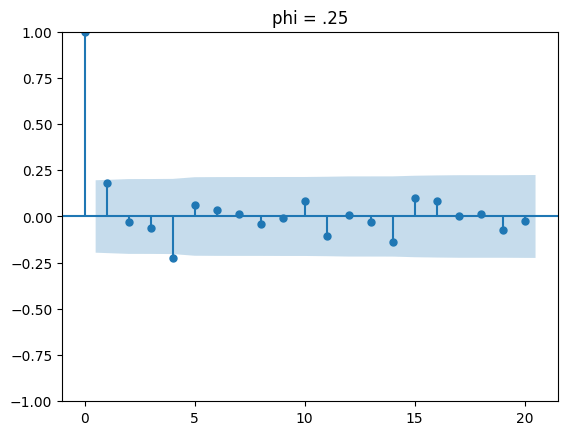

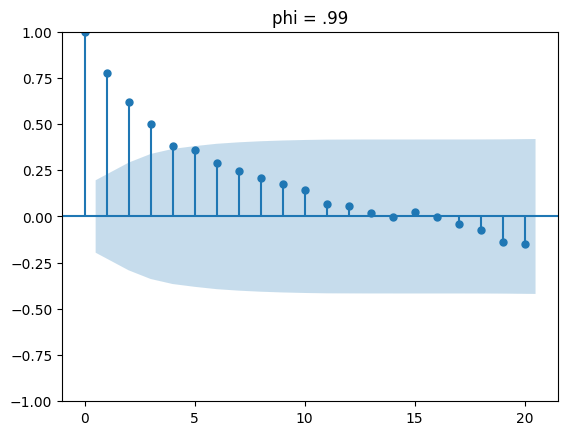

In [20]:
#ACF 자동 생성
plot_acf(ex_AR3_1)
plt.title('phi = .25')
plt.show()

plot_acf(ex_AR3_2)
plt.title('phi = .99')
plt.show()

#### PACF 시각화

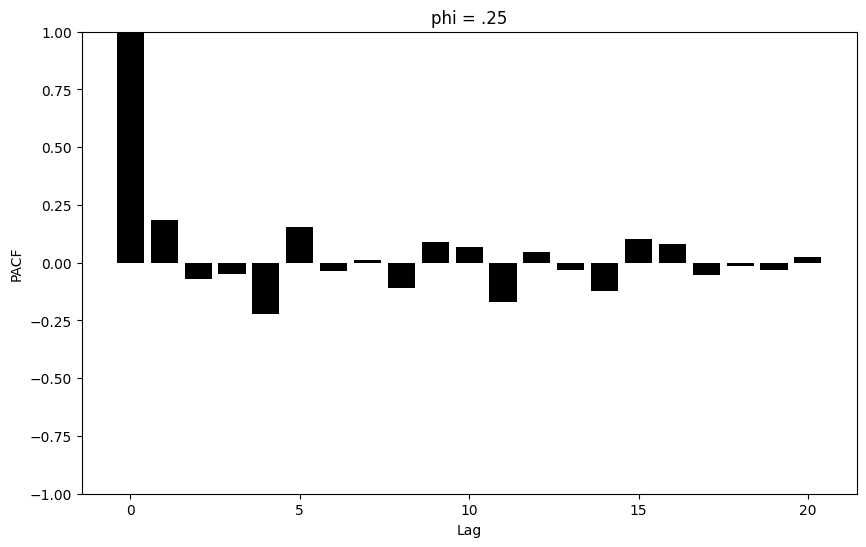

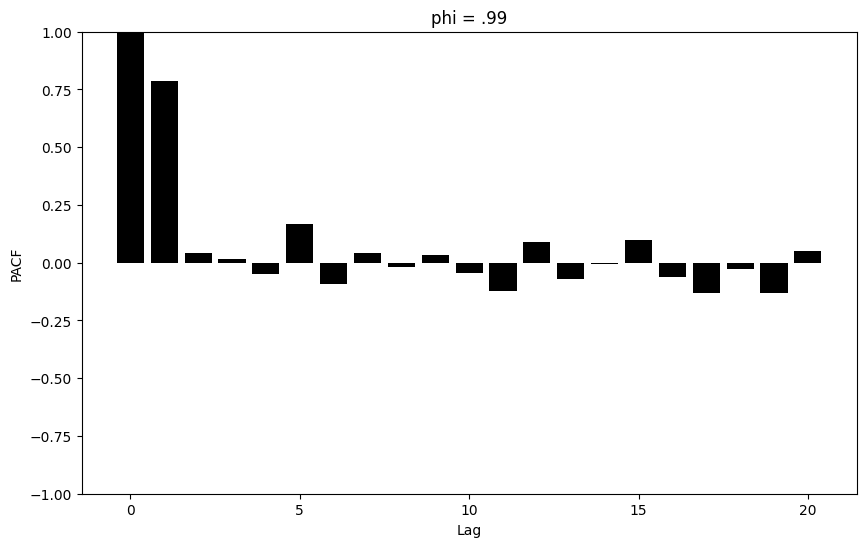

In [21]:
#PACF 시각화 함수
def show_PACF(series, title, start=0, nlags=None):
    plt.figure(figsize=(10, 6))
    PACF = pacf(series, nlags=nlags)
    plt.bar(range(start, PACF.shape[0]), PACF[start:], color='black')
    plt.xlabel("Lag")
    plt.ylabel("PACF")
    plt.ylim(-1, 1)
    plt.title(title)
    plt.show()
    
#수동 시각화
show_PACF(ex_AR3_1, "phi = .25")
show_PACF(ex_AR3_2, "phi = .99")

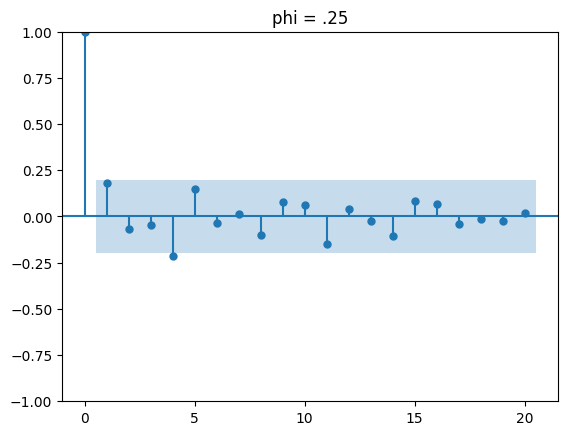

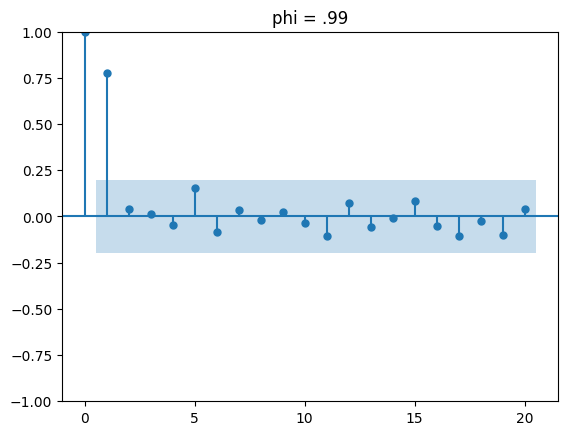

In [22]:
#모듈을 통한 시각화
plot_pacf(ex_AR3_1)
plt.title('phi = .25')
plt.show()

plot_pacf(ex_AR3_2)
plt.title('phi = .99')
plt.show()

# 3.2.4 이동평균(MA)

## 1. MA(1) 예시

#### 모듈 불러오기

In [23]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### 데이터 생성 및 시각화

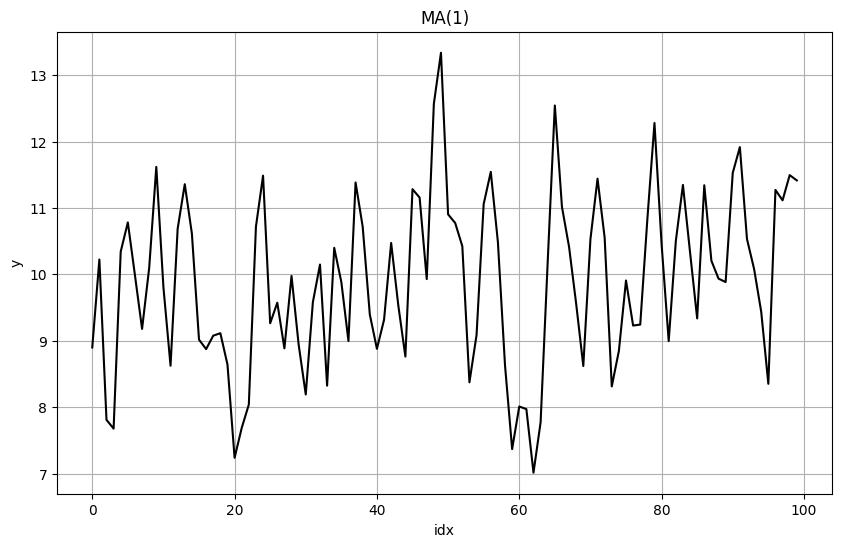

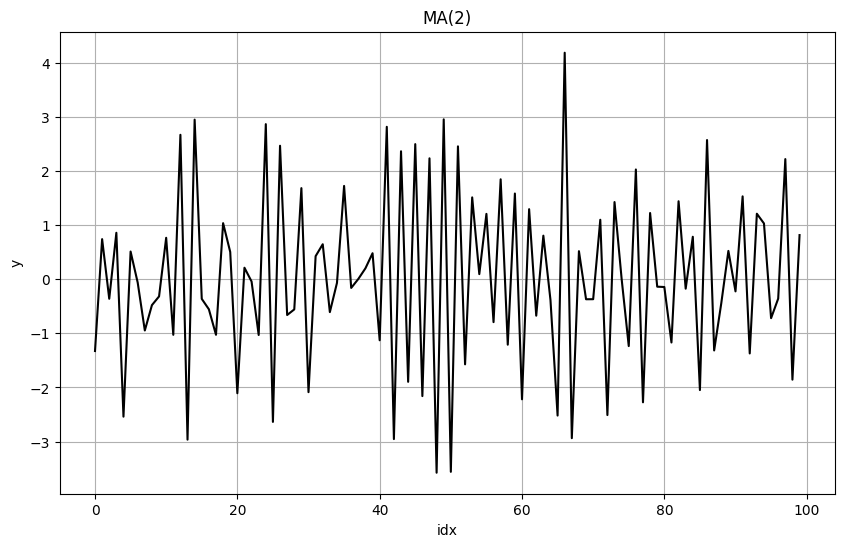

In [24]:
#시각화 함수 정의
def plot_series(series, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(series,  color='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

#예시 생성 함수
def MA1(c=0, theta=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c + noise[0]]
    for i in range(1, n):
        data.append(c + noise[i] + theta * noise[i-1])
    return data

def MA2(c=0, theta1=0, theta2=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c + noise[0], c + theta1 * noise[0] + noise[1]]
    for i in range(2, n):
        data.append(c + noise[i] + theta1 * noise[i-1] + theta2 * noise[i-2])
    return data

#시각화
ex_MA1_1 = pd.Series(MA1(c=10, theta=0.75))
plot_series(ex_MA1_1, "idx", "y", "MA(1)")

ex_MA1_2 = pd.Series(MA2(theta1=-1, theta2=0.75))
plot_series(ex_MA1_2, "idx", "y", "MA(2)")

## 2. MA(1) ACF, PACF 예시

#### 데이터 생성 및 시각화

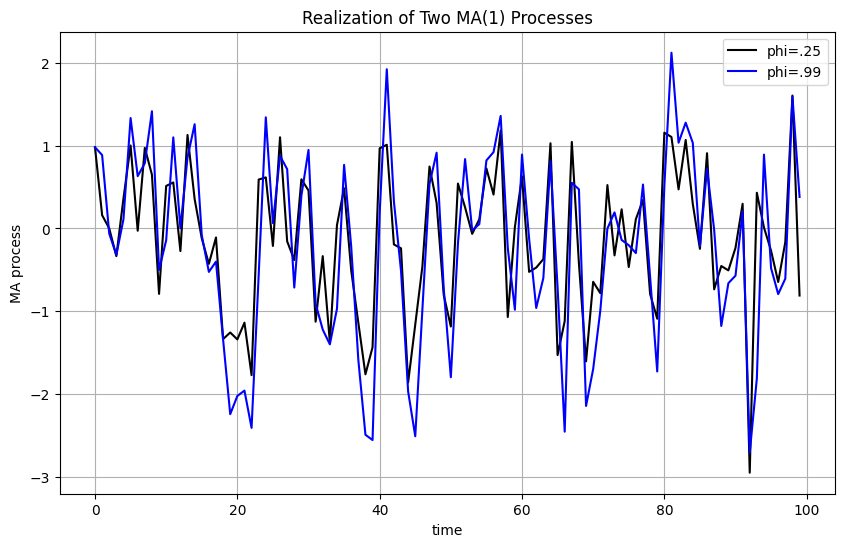

In [25]:
#예시 생성
noise = np.random.normal(0, 1, 100)

data = [noise[0]]
for i in range(1, 100):
    data.append(noise[i] + 0.25* noise[i-1])
ex_MA2_1 = pd.Series(data)

data = [noise[0]]
for i in range(1, 100):
    data.append(noise[i] + 0.99 * noise[i-1])
ex_MA2_2 = pd.Series(data)

#시각화
plt.figure(figsize=(10, 6))
plt.plot(ex_MA2_1,  color='black', label='phi=.25')
plt.plot(ex_MA2_2,  color='b', label='phi=.99')
plt.xlabel("time")
plt.ylabel("MA process")
plt.title("Realization of Two MA(1) Processes")
plt.grid(True)
plt.legend()
plt.show()

### ACF 시각화

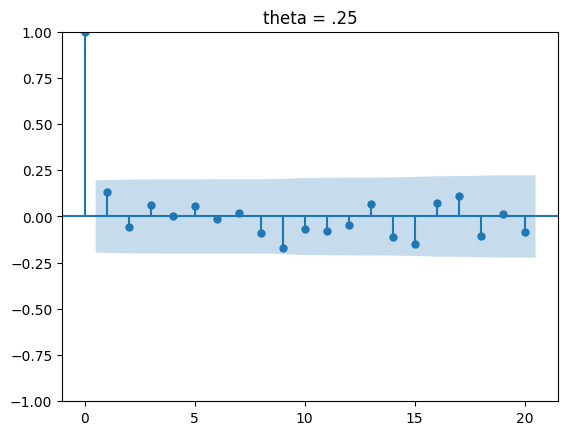

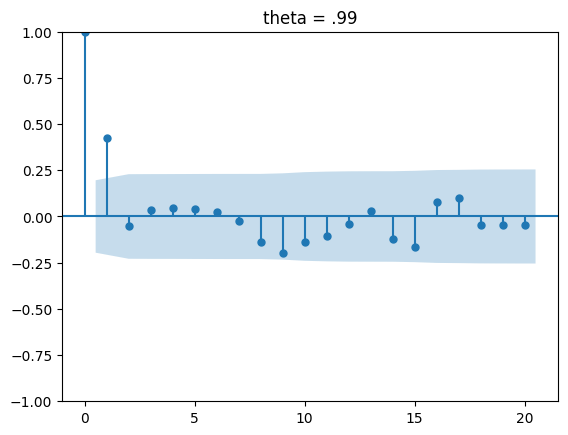

In [27]:
#ACF 자동 생성
plot_acf(ex_MA2_1)
plt.title('theta = .25')
plt.show()

plot_acf(ex_MA2_2)
plt.title('theta = .99')
plt.show()

### PACF 시각화

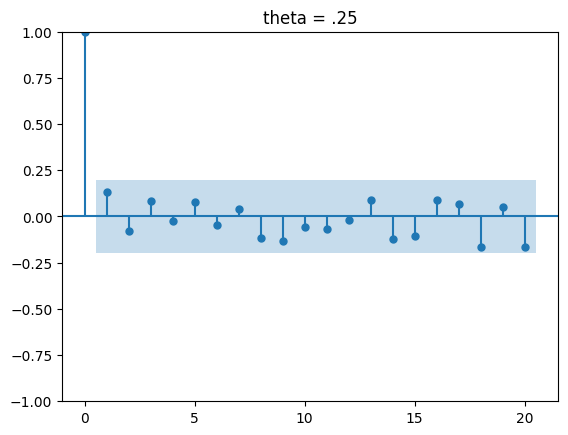

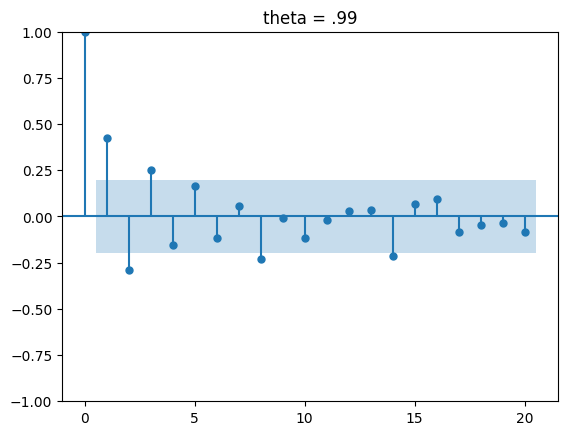

In [28]:
#PACF 자동 시각화
plot_pacf(ex_MA2_1)
plt.title('theta = .25')
plt.show()

plot_pacf(ex_MA2_2)
plt.title('theta = .99')
plt.show()

# 3.2.5 정상성 검정

## 1. ADF 검정

#### 모듈 불러오기

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

#### 데이터 생성 및 시각화

In [29]:
#예시 생성
noise = np.random.normal(0, 1, 100)
data = [noise[0]]
for i in range(1, 100):
    data.append(0.5 * data[i-1] + noise[i])
ex_1 = pd.Series(data)

noise = np.random.normal(0, 1, 100)
data = [noise[0]]
for i in range(1, 100):
    data.append(0.5 * data[i-1] + noise[i] + 0.05 * i)
ex_2 = pd.Series(data)

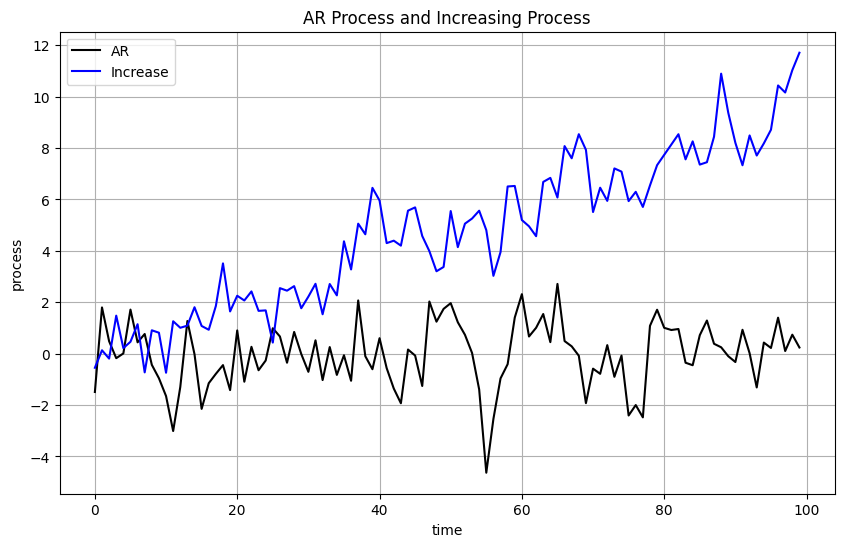

In [30]:
#시각화
plt.figure(figsize=(10, 6))
plt.plot(ex_1,  color='black', label='AR')
plt.plot(ex_2,  color='b', label='Increase')
plt.xlabel("time")
plt.ylabel("process")
plt.title("AR Process and Increasing Process")
plt.grid(True)
plt.legend()
plt.show()

#### 정상성 확인

In [25]:
#Adfuller test
print(adfuller(ex_1)[1])
print(adfuller(ex_2)[1])

3.168948301583155e-05
0.9199414055824245


## 2. KPSS 검정

#### 모듈 불러오기

In [26]:
#모듈 불러오기
from statsmodels.tsa.stattools import kpss

#### 정상성 확인

In [27]:
#kpss test
print(kpss(ex_1))
print(kpss(ex_2))

(0.19296383637700915, 0.1, 2, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(1.6426527444312031, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


# 3.2.6 ARIMA

### 이집트 수출

#### 모듈과 데이터 불러오기

In [28]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#데이터 불러오기
global_economy = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/global_economy.csv')
global_economy['Year'] = pd.to_datetime(global_economy['Year'], format='%Y')
egypt_exports = global_economy[global_economy['Code'] == 'EGY']
egypt_exports.index = egypt_exports['Year']
egypt_exports

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
Year,,,,,,,,,
1960-01-01,"Egypt, Arab Rep.",EGY,1960-01-01,NaN,NaN,1.208721,21.825505,19.866193,26996533.0
1961-01-01,"Egypt, Arab Rep.",EGY,1961-01-01,NaN,5.161114,1.217104,19.741886,17.646307,27744712.0
1962-01-01,"Egypt, Arab Rep.",EGY,1962-01-01,NaN,3.875617,1.180554,19.518471,15.052380,28506176.0
1963-01-01,"Egypt, Arab Rep.",EGY,1963-01-01,NaN,10.518093,1.189368,23.586927,17.758857,29281250.0
1964-01-01,"Egypt, Arab Rep.",EGY,1964-01-01,NaN,11.507577,1.232911,24.874237,18.398046,30071102.0
1965-01-01,"Egypt, Arab Rep.",EGY,1965-01-01,4.948668e+09,4.914042,1.415863,20.132421,17.130876,30875964.0
1966-01-01,"Egypt, Arab Rep.",EGY,1966-01-01,5.278006e+09,5.046404,1.543806,20.484194,16.333374,31697616.0
1967-01-01,"Egypt, Arab Rep.",EGY,1967-01-01,5.605484e+09,0.805264,1.554642,19.113934,16.825785,32534021.0
1968-01-01,"Egypt, Arab Rep.",EGY,1968-01-01,5.932243e+09,-1.606792,1.528590,17.463568,11.799921,33377259.0


#### GDP 대비 수출량 시각화

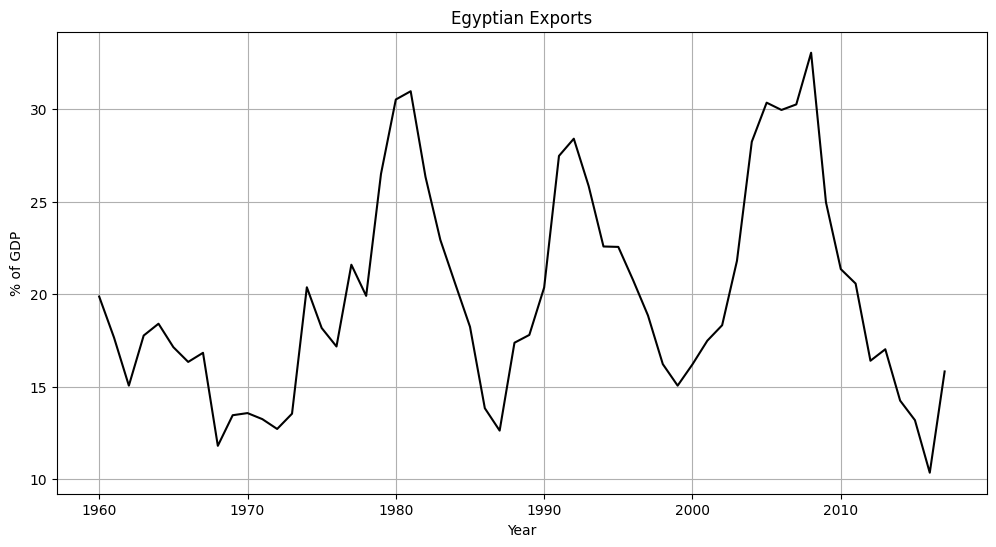

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(egypt_exports['Exports'], color='black')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Egyptian Exports')
plt.grid(True)
plt.show()

#### ACF, PACF 시각화

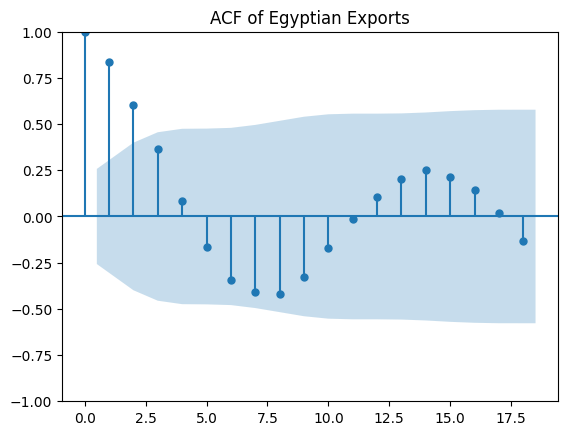

In [30]:
#ACF 시각화
plot_acf(egypt_exports['Exports'])
plt.title('ACF of Egyptian Exports')
plt.show()

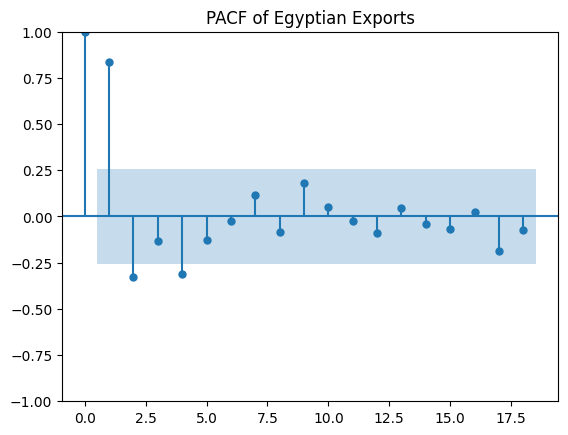

In [31]:
#PACF 시각화
plot_pacf(egypt_exports['Exports'])
plt.title('PACF of Egyptian Exports')
plt.show()

#### 모델 적합 결과

In [32]:
#ARIMA 모델 적합
model = ARIMA(egypt_exports['Exports'], order=(2,0,1))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Exports   No. Observations:                   58
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -141.566
Date:                Fri, 03 Jan 2025   AIC                            293.132
Time:                        13:51:57   BIC                            303.434
Sample:                    01-01-1960   HQIC                           297.145
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1790      0.972     20.766      0.000      18.274      22.084
ar.L1          1.6764      0.127     13.239      0.000       1.428       1.925
ar.L2         -0.8034      0.102     -7.905      0.0

#### 잔차를 통한 모델 적합성 확인

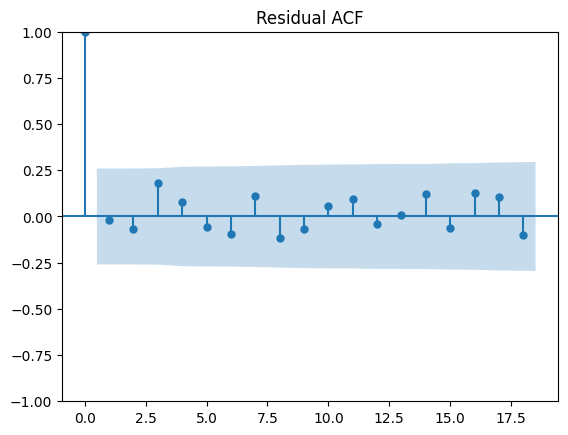

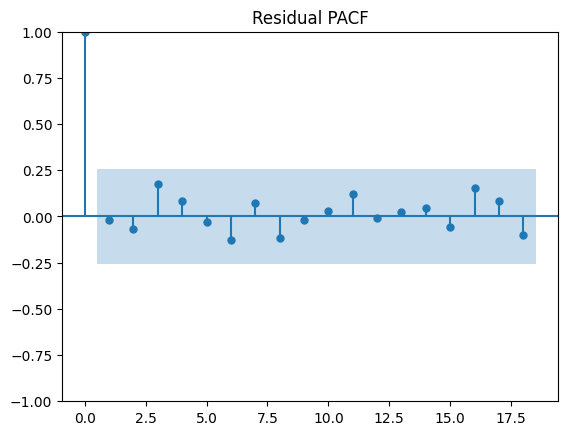

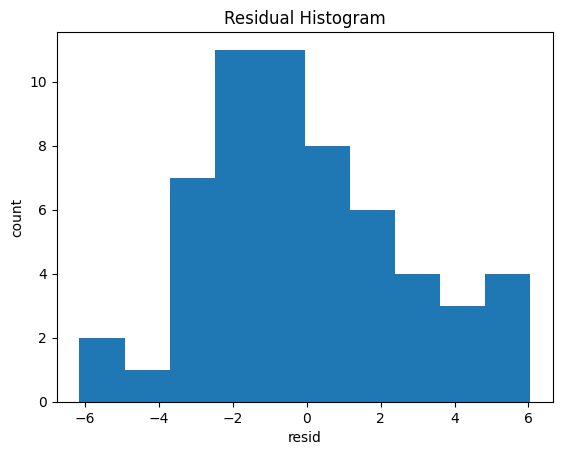

In [33]:
#잔차 ACF 시각화
plot_acf(fit.resid[1:])
plt.title('Residual ACF')
plt.show()

#잔차 PACF 시각화
plot_pacf(fit.resid[1:])
plt.title('Residual PACF')
plt.show()

#잔차 히스토그램 시각화
plt.hist(fit.resid[1:])
plt.xlabel("resid")
plt.ylabel("count")
plt.title("Residual Histogram")
plt.show()

# 3.2.7 모델 선택

### 중앙 아프리카 공화국 수출

#### 모듈과 데이터 불러오기

In [34]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

#pmdarima는 numpy의 2.x 버전을 지원하지 않습니다. 아래 코드를 통해 버전을 낮춰야합니다.
#pip install "numpy<2"
#이번 예제 이후에는 pmdarima를 지양합니다.

#데이터 불러오기
global_economy = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/global_economy.csv')
global_economy['Year'] = pd.to_datetime(global_economy['Year'], format='%Y')
caf_exports = global_economy[global_economy['Code'] == 'CAF']
caf_exports.index = caf_exports['Year']
caf_exports

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
Year,,,,,,,,,
1960-01-01,Central African Republic,CAF,1960-01-01,1.121556e+08,NaN,NaN,34.181812,23.272724,1503508.0
1961-01-01,Central African Republic,CAF,1961-01-01,1.231346e+08,4.953554,NaN,35.761589,26.490066,1529227.0
1962-01-01,Central African Republic,CAF,1962-01-01,1.244827e+08,-3.713800,NaN,37.704907,24.590165,1556661.0
1963-01-01,Central African Republic,CAF,1963-01-01,1.293791e+08,-0.707011,NaN,38.485805,25.236592,1585763.0
1964-01-01,Central African Republic,CAF,1964-01-01,1.420251e+08,2.080325,NaN,40.804590,28.448269,1616516.0
1965-01-01,Central African Republic,CAF,1965-01-01,1.505748e+08,0.947579,NaN,37.669377,27.100268,1648833.0
1966-01-01,Central African Republic,CAF,1966-01-01,1.579300e+08,0.644784,NaN,42.525773,28.350515,1682885.0
1967-01-01,Central African Republic,CAF,1967-01-01,1.638205e+08,4.676613,NaN,46.898238,26.302730,1718603.0
1968-01-01,Central African Republic,CAF,1968-01-01,1.917674e+08,1.404113,NaN,39.631225,34.312298,1755344.0


#### 중앙 아프리카 공화국 수출 시각화

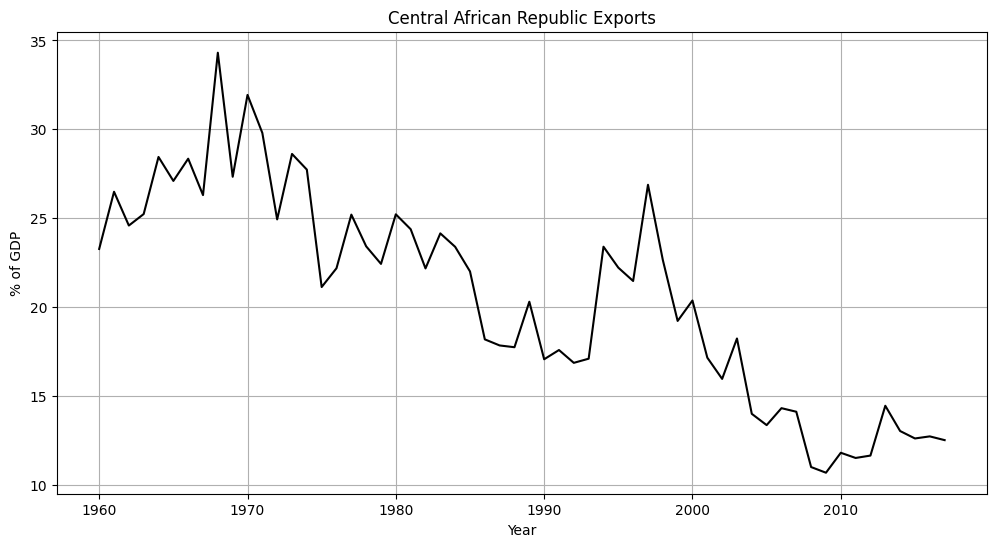

In [35]:
#시각화
plt.figure(figsize=(12, 6))
plt.plot(caf_exports['Exports'], color='black')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Central African Republic Exports')
plt.grid(True)
plt.show()

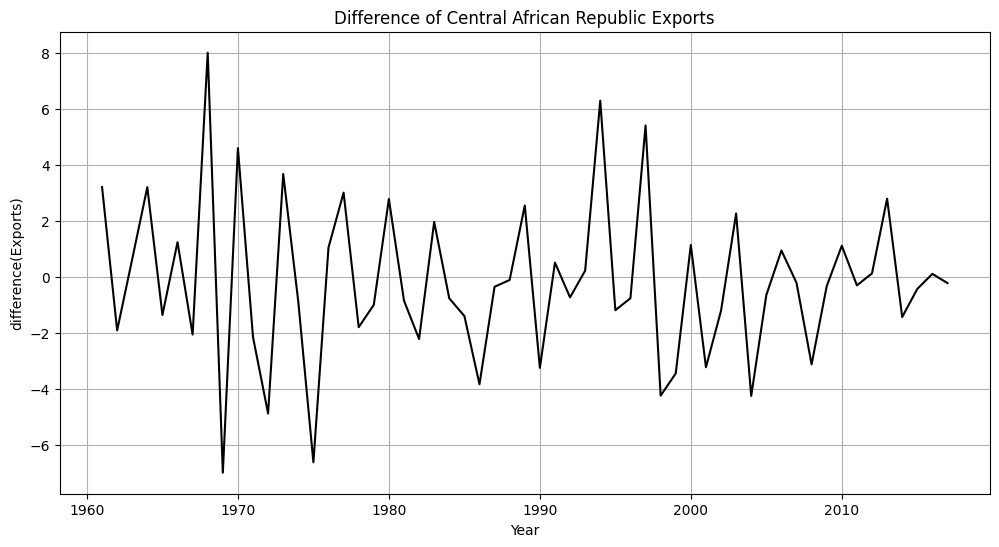

In [36]:
#차분 시각화
plt.figure(figsize=(12, 6))
plt.plot(caf_exports['Exports'].diff()[1:], color='black')
plt.xlabel('Year')
plt.ylabel('difference(Exports)')
plt.title('Difference of Central African Republic Exports')
plt.grid(True)
plt.show()

#### ACF, PACF 시각화

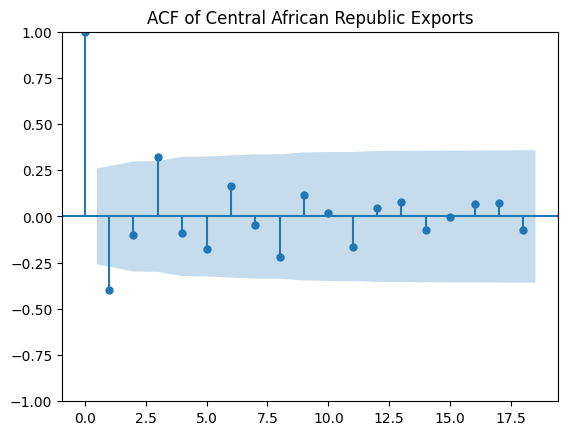

In [37]:
#ACF 시각화
plot_acf(caf_exports['Exports'].diff()[1:])
plt.title('ACF of Central African Republic Exports')
plt.show()

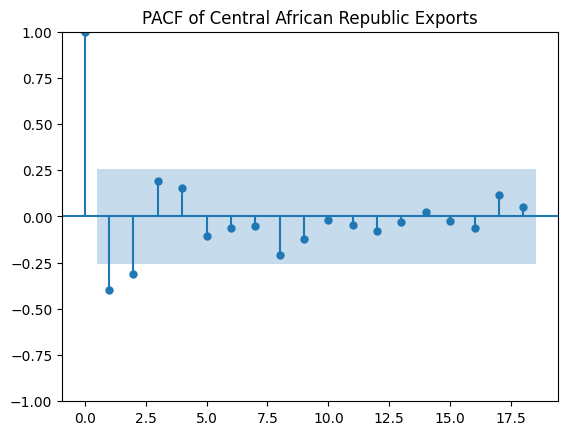

In [38]:
#PACF 시각화
plot_pacf(caf_exports['Exports'].diff()[1:])
plt.title('PACF of Central African Republic Exports')
plt.show()

#### 최적의 ARIMA 모델 선택

In [39]:
#모델 자동 탐색
auto_model = pm.auto_arima(caf_exports['Exports'], start_p=3, d=1, start_q=0, seasonal=False, information_criterion="aicc", m=1)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -133.002
Date:                Fri, 03 Jan 2025   AIC                            274.005
Time:                        13:51:59   BIC                            282.177
Sample:                    01-01-1960   HQIC                           277.181
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4419      0.140     -3.152      0.002      -0.717      -0.167
ar.L2         -0.1850      0.176     -1.051      0.293      -0.530       0.160
ar.L3          0.2055      0.135      1.527      0.1

#### 모델 적합성 검증

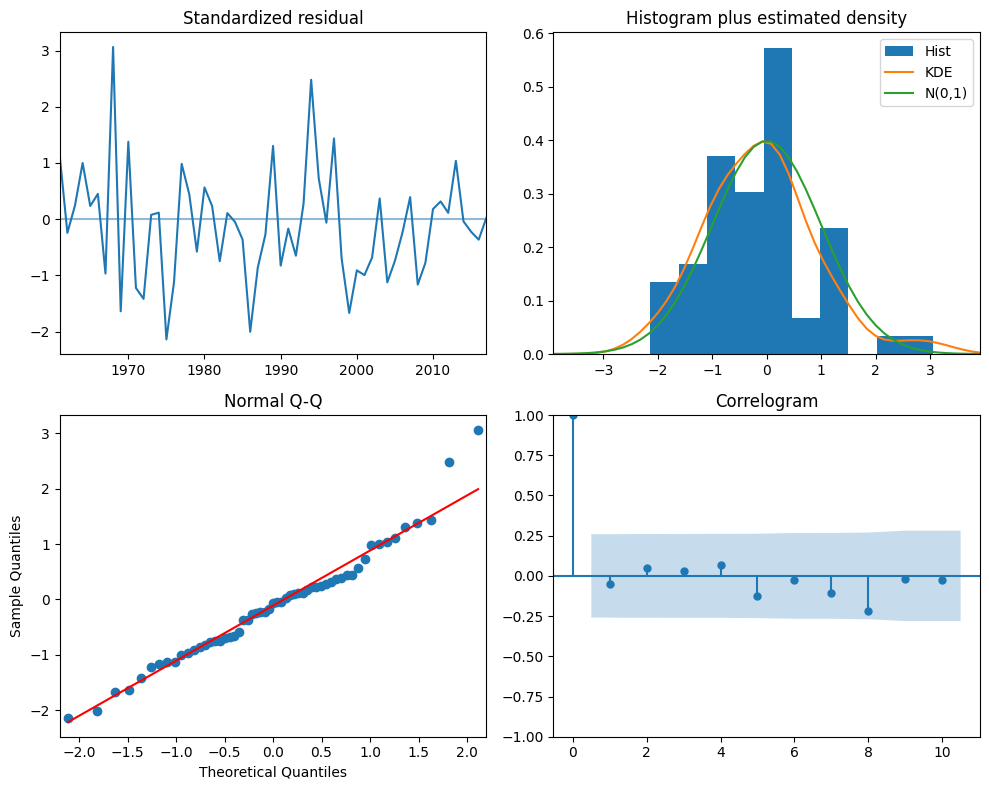

In [40]:
#잔차 확인
auto_model.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

# 3.2.8 SARIMA(계절성 ARIMA) 모델

### 1) 미국 레져 고용

#### 모듈과 데이터 불러오기

In [41]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

#pmdarima는 numpy의 2.x 버전을 지원하지 않습니다. 아래 코드를 통해 버전을 낮춰야합니다.
#pip install "numpy<2"
#이번 예제 이후에는 pmdarima를 지양합니다.

#데이터 불러오기
us_emp = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/us_employment.csv")
us_emp['Month'] = pd.to_datetime(us_emp['Month'], format='%Y %m')
us_leis = us_emp[us_emp['Title'] == 'Leisure and Hospitality']
us_leis.index = us_leis['Month']
us_leis = us_leis.loc['2000/1/1':]
us_leis

,Month,Series_ID,Title,Employed
Month,,,,
2000-01-01,2000-01-01,CEU7000000001,Leisure and Hospitality,11056.0
2000-02-01,2000-02-01,CEU7000000001,Leisure and Hospitality,11180.0
2000-03-01,2000-03-01,CEU7000000001,Leisure and Hospitality,11435.0
2000-04-01,2000-04-01,CEU7000000001,Leisure and Hospitality,11740.0
2000-05-01,2000-05-01,CEU7000000001,Leisure and Hospitality,12060.0
...,...,...,...,...
2019-05-01,2019-05-01,CEU7000000001,Leisure and Hospitality,16961.0
2019-06-01,2019-06-01,CEU7000000001,Leisure and Hospitality,17403.0
2019-07-01,2019-07-01,CEU7000000001,Leisure and Hospitality,17463.0


#### 레져 고용 시각화

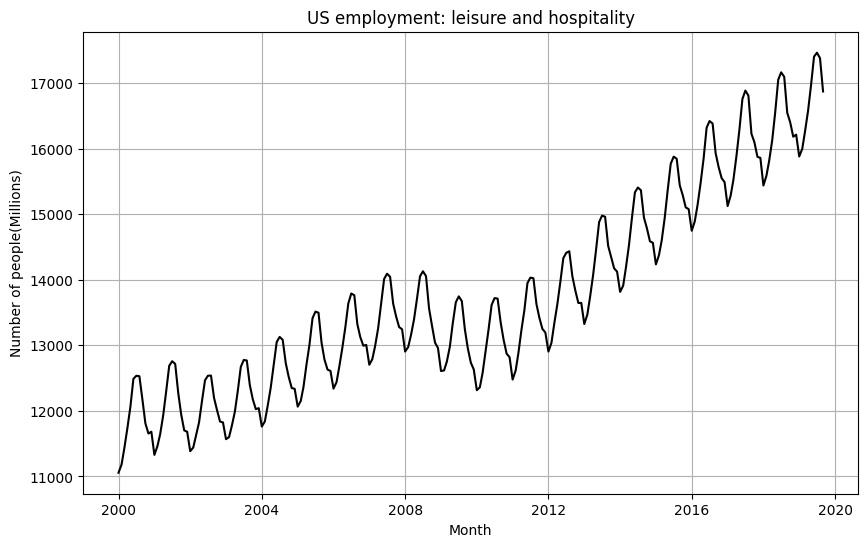

In [42]:
#시각화
plt.figure(figsize=(10, 6))
plt.plot(us_leis['Employed'], color='black')
plt.xlabel('Month')
plt.ylabel('Number of people(Millions)')
plt.title('US employment: leisure and hospitality')
plt.grid(True)
plt.show()

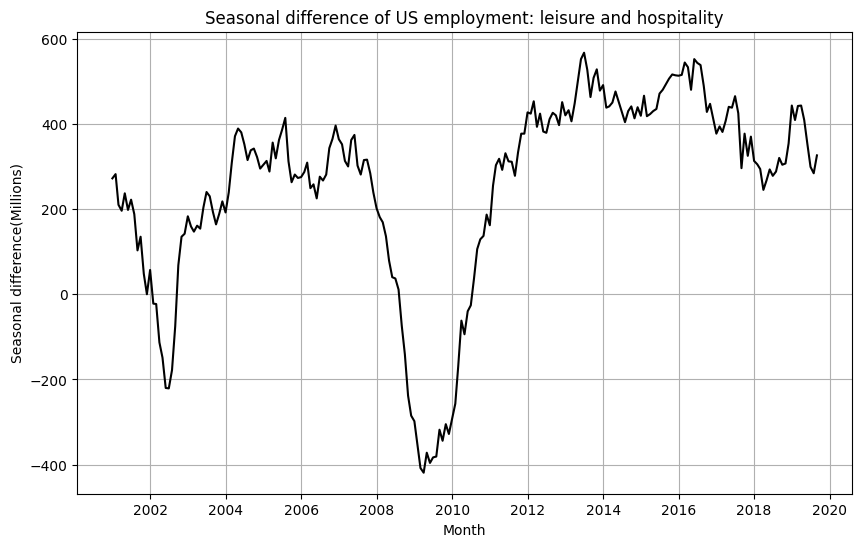

In [43]:
#차분 시각화
plt.figure(figsize=(10, 6))
plt.plot(us_leis['Employed'].diff(12)[12:], color='black')
plt.xlabel('Month')
plt.ylabel('Seasonal difference(Millions)')
plt.title('Seasonal difference of US employment: leisure and hospitality')
plt.grid(True)
plt.show()

#### ACF, PACF 시각화

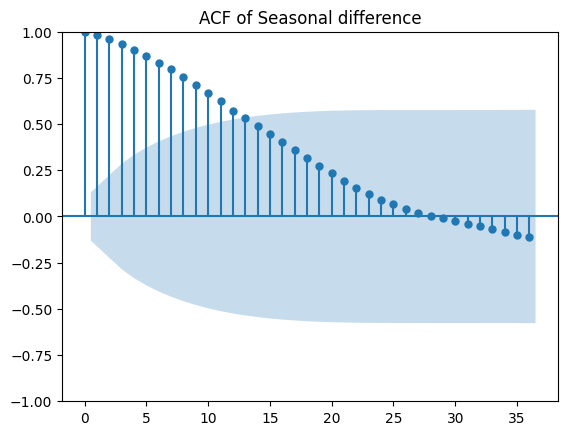

In [44]:
#ACF 시각화
plot_acf(us_leis['Employed'].diff(12)[12:], lags=36)
plt.title("ACF of Seasonal difference")
plt.show()

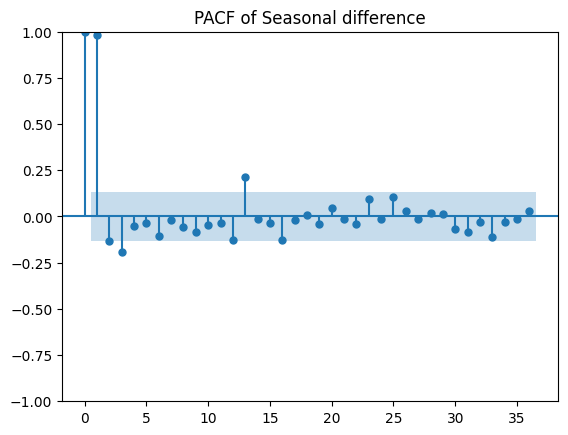

In [45]:
#PACF 시각화
plot_pacf(us_leis['Employed'].diff(12)[12:], lags=36)
plt.title("PACF of Seasonal difference")
plt.show()

#### 2차 차분 및 시각화

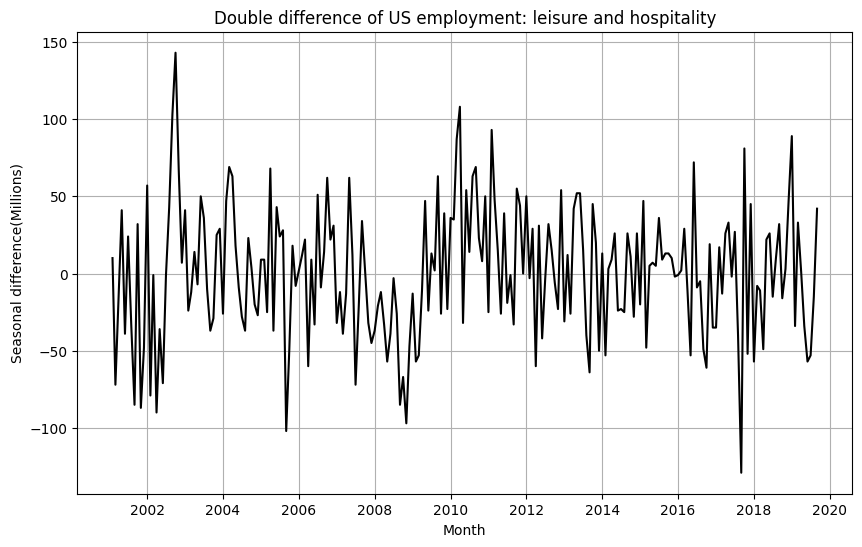

In [46]:
#2차 차분
doubdiff_us_leis = us_leis['Employed'].diff(12)[12:].diff()[1:]

#2차 차분 시각화
plt.figure(figsize=(10, 6))
plt.plot(doubdiff_us_leis, color='black')
plt.xlabel('Month')
plt.ylabel('Seasonal difference(Millions)')
plt.title('Double difference of US employment: leisure and hospitality')
plt.grid(True)
plt.show()

#### 2차 차분 ACF, PACF 시각화

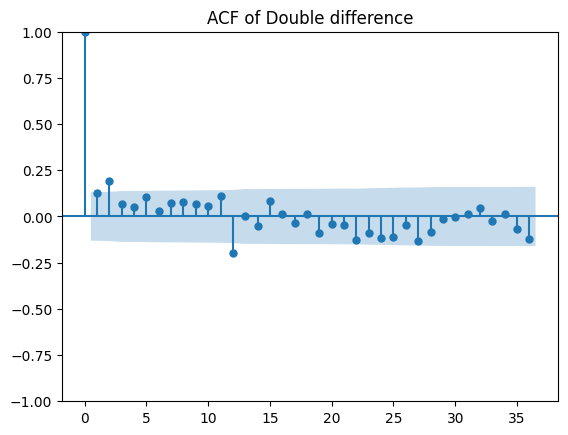

In [47]:
#ACF 시각화
plot_acf(doubdiff_us_leis, lags=36)
plt.title("ACF of Double difference")
plt.show()

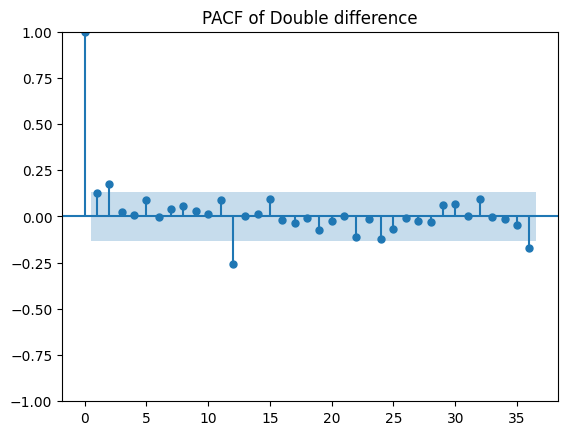

In [48]:
#PACF 시각화
plot_pacf(doubdiff_us_leis, lags=36)
plt.title("PACF of Double difference")
plt.show()

#### 최적의 ARIMA 모델 선택

In [49]:
#모델 자동 선택
auto_model = pm.auto_arima(us_leis['Employed'], start_p=2, d=1, start_q=0, start_P=1, D=1, start_Q=1, information_criterion="aicc", m=12)
print(auto_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  237
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1135.376
Date:                                 Fri, 03 Jan 2025   AIC                           2280.751
Time:                                         13:52:25   BIC                           2297.809
Sample:                                     01-01-2000   HQIC                          2287.637
                                          - 09-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9055      0.070     12.988      0.000       0.769       1

In [50]:
#모델 수동 선택 1안
model = ARIMA(us_leis['Employed'], order=(0,1,2), seasonal_order=(0,1,1,12))
fit = model.fit()
print(fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Employed   No. Observations:                  237
Model:             ARIMA(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1141.102
Date:                            Fri, 03 Jan 2025   AIC                           2290.204
Time:                                    13:52:26   BIC                           2303.851
Sample:                                01-01-2000   HQIC                          2295.713
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1442      0.059      2.445      0.014       0.029       0.260
ma.L2          0.2017      0.069   

In [51]:
#모델 수동 선택 2안
model = ARIMA(us_leis['Employed'], order=(2,1,0), seasonal_order=(0,1,1,12))
fit = model.fit()
print(fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Employed   No. Observations:                  237
Model:             ARIMA(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1140.082
Date:                            Fri, 03 Jan 2025   AIC                           2288.164
Time:                                    13:52:26   BIC                           2301.810
Sample:                                01-01-2000   HQIC                          2293.672
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1562      0.060      2.601      0.009       0.038       0.274
ar.L2          0.1985      0.068   

#### 모델 적합성 검증

                                       SARIMAX Results                                       
Dep. Variable:                              Employed   No. Observations:                  237
Model:             ARIMA(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1135.376
Date:                               Fri, 03 Jan 2025   AIC                           2280.751
Time:                                       13:52:27   BIC                           2297.809
Sample:                                   01-01-2000   HQIC                          2287.637
                                        - 09-01-2019                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9055      0.070     12.988      0.000       0.769       1.042
ma.L1      

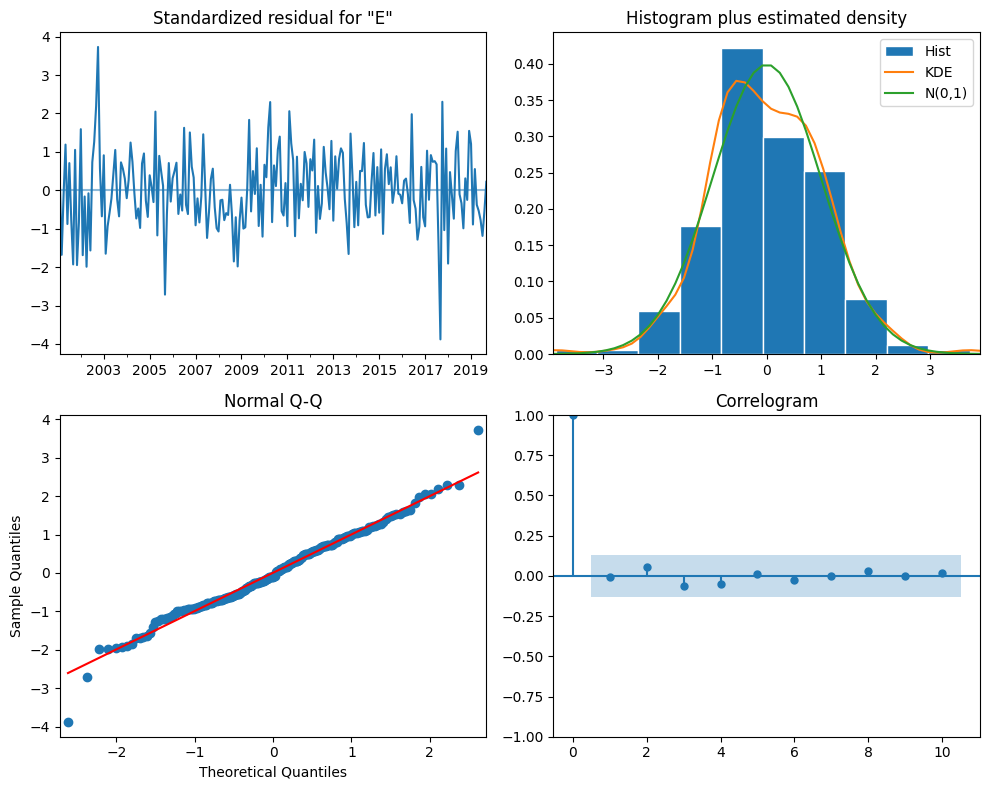

In [52]:
#자동 선택 모델
model = ARIMA(us_leis['Employed'], order=(1,1,1), seasonal_order=(0,1,2,12))
fit = model.fit()
print(fit.summary())

#잔차 확인
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

#### 모델을 이용한 예측

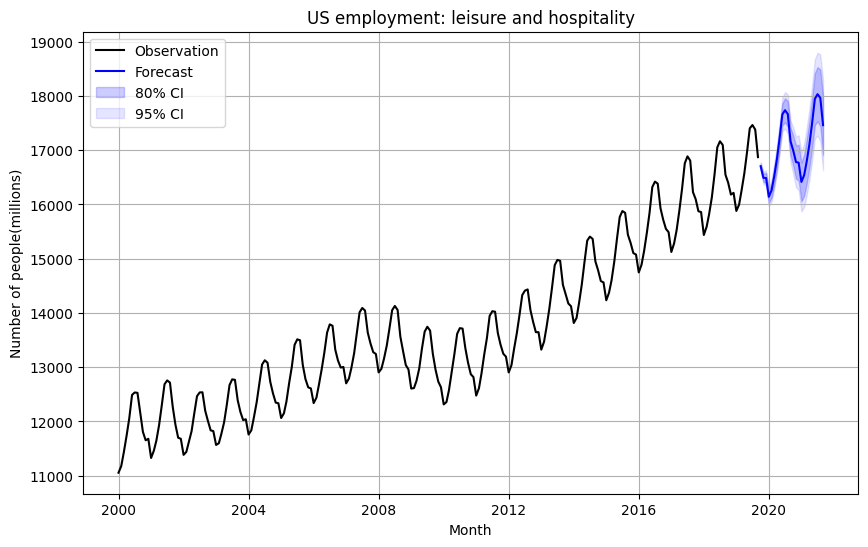

In [53]:
#SARIMA 예측값 구하기
forecast_result = fit.get_forecast(24)
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,1]

#예측 시각화
plt.figure(figsize=(10, 6))
plt.plot(us_leis['Employed'], label='Observation', color='black')
plt.plot(forecast_mean, label='Forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
plt.xlabel('Month')
plt.ylabel('Number of people(millions)')
plt.title('US employment: leisure and hospitality')
plt.grid(True)
plt.legend()
plt.show()

### 2) 코르티코스테로이드 약물 판매량

#### 모듈과 데이터 불러오기

In [54]:
#모듈 불러오기
import numpy as np

#데이터 불러오기
h02 = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/h02.csv", index_col=0)
h02.index = pd.date_range(start='1/1/1992', periods=h02.shape[0], freq='1MS')

h02

,x
1992-01-01,0.429795
1992-02-01,0.400906
1992-03-01,0.432159
1992-04-01,0.492543
1992-05-01,0.502369
...,...
2008-08-01,0.761822
2008-09-01,0.649435
2008-10-01,0.827887
2008-11-01,0.816255


#### 코르티코스테로이드 약물 판매량 시각화 및 로그화

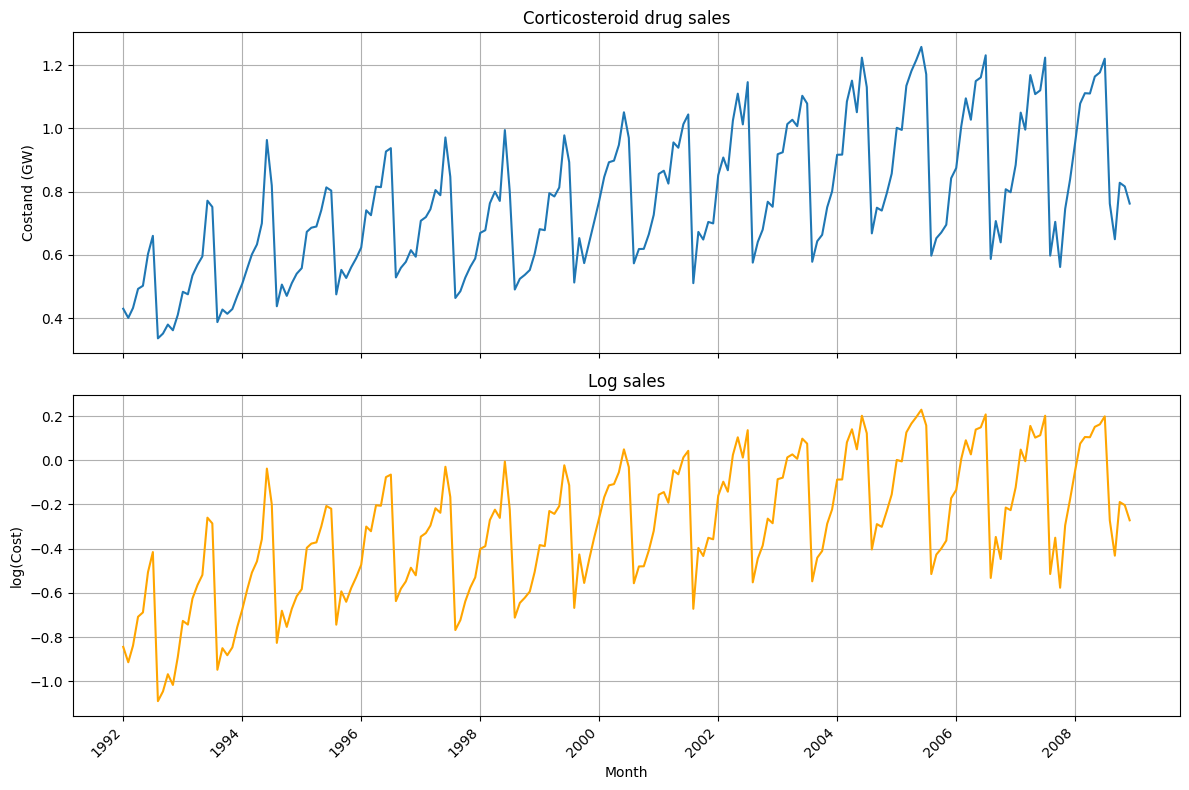

In [55]:
#로그화 함수 정의
def log_series(series):
    tmp = np.log(series)
    return pd.Series(tmp, series.index)

#원본, 로그화 데이터 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(h02.x)
ax1.set_ylabel('Costand (GW)')
ax1.set_title('Corticosteroid drug sales')
ax1.grid(True)

ax2.plot(log_series(h02.x), color='orange')
ax2.set_ylabel('log(Cost)')
ax2.set_title('Log sales')
ax2.grid(True)

ax2.set_xlabel('Month')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 계절 차분화 및 정상성 확인

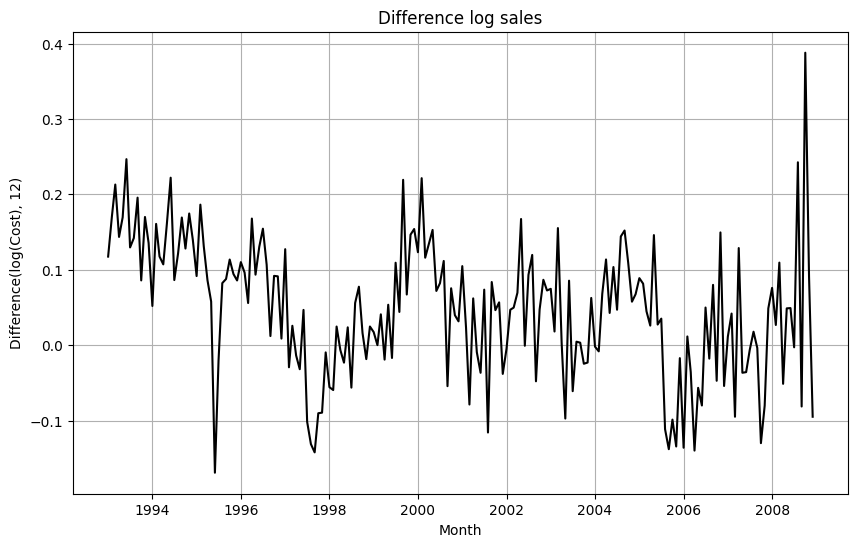

In [56]:
#계절 차분화 시각화
plt.figure(figsize=(10, 6))
plt.plot(log_series(h02.x).diff(12)[12:], color='black')
plt.xlabel('Month')
plt.ylabel('Difference(log(Cost), 12)')
plt.title('Difference log sales')
plt.grid(True)
plt.show()

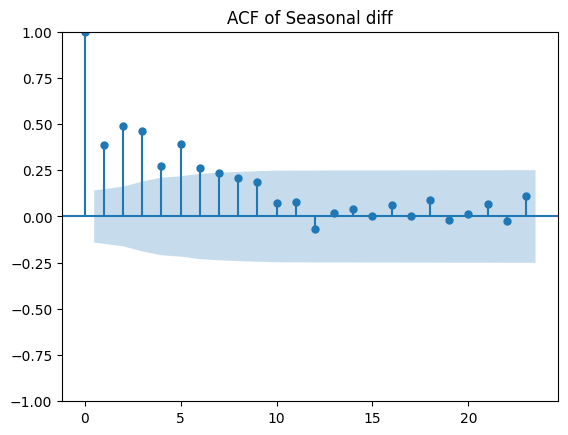

In [57]:
#ACF 시각화
plot_acf(log_series(h02.x).diff(12)[12:])
plt.title("ACF of Seasonal diff")
plt.show()

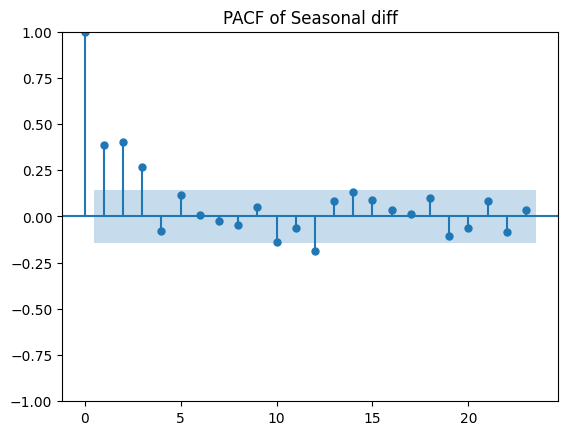

In [58]:
#ACF 시각화
plot_pacf(log_series(h02.x).diff(12)[12:])
plt.title("PACF of Seasonal diff")
plt.show()

#### 최적의 ARIMA 모델 선택

                                    SARIMAX Results                                     
Dep. Variable:                                x   No. Observations:                  204
Model:             ARIMA(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 287.764
Date:                          Fri, 03 Jan 2025   AIC                           -563.527
Time:                                  13:52:30   BIC                           -543.982
Sample:                              01-01-1992   HQIC                          -555.611
                                   - 12-01-2008                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0985      0.068      1.449      0.147      -0.035       0.232
ar.L2          0.3980      0.053      7.561      0.

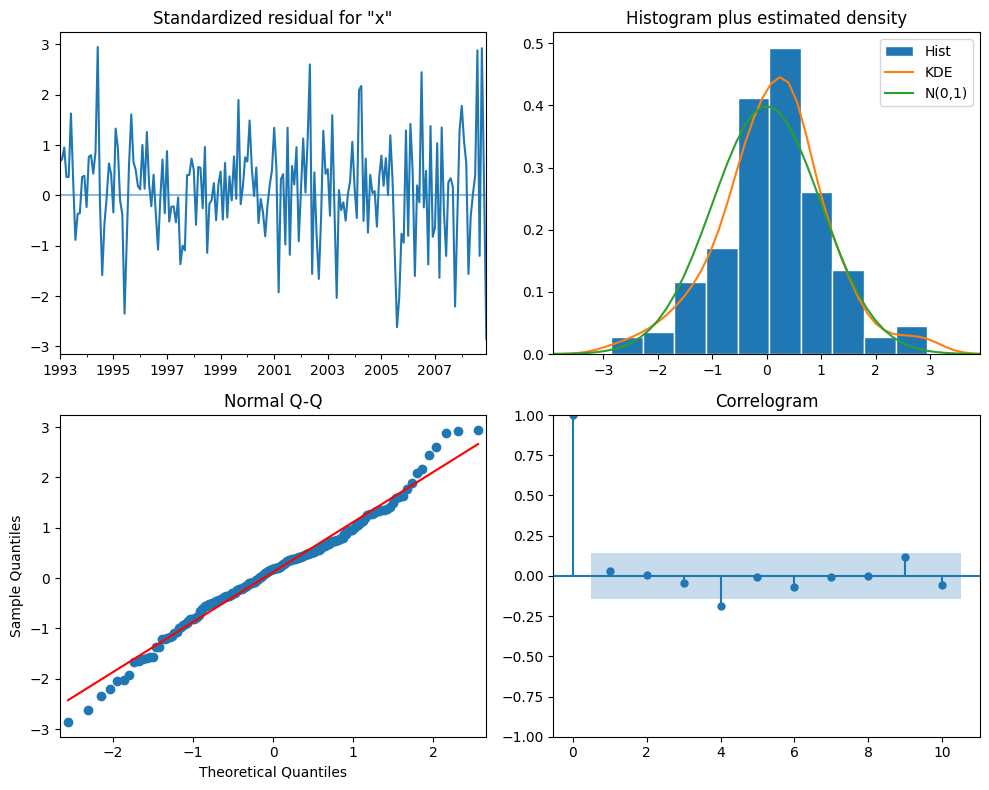

In [59]:
#모델 1안 적합
model = ARIMA(h02.x, order=(3,0,0), seasonal_order=(2,1,0,12))
fit = model.fit()
print(fit.summary())

#모델 1안 잔차 확인
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                                  x   No. Observations:                  204
Model:             ARIMA(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 284.000
Date:                            Fri, 03 Jan 2025   AIC                           -560.000
Time:                                    13:52:31   BIC                           -546.991
Sample:                                01-01-1992   HQIC                          -554.731
                                     - 12-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8430      0.064    -13.261      0.000      -0.968      -0.718
ar.L2         -0.3959      0.058   

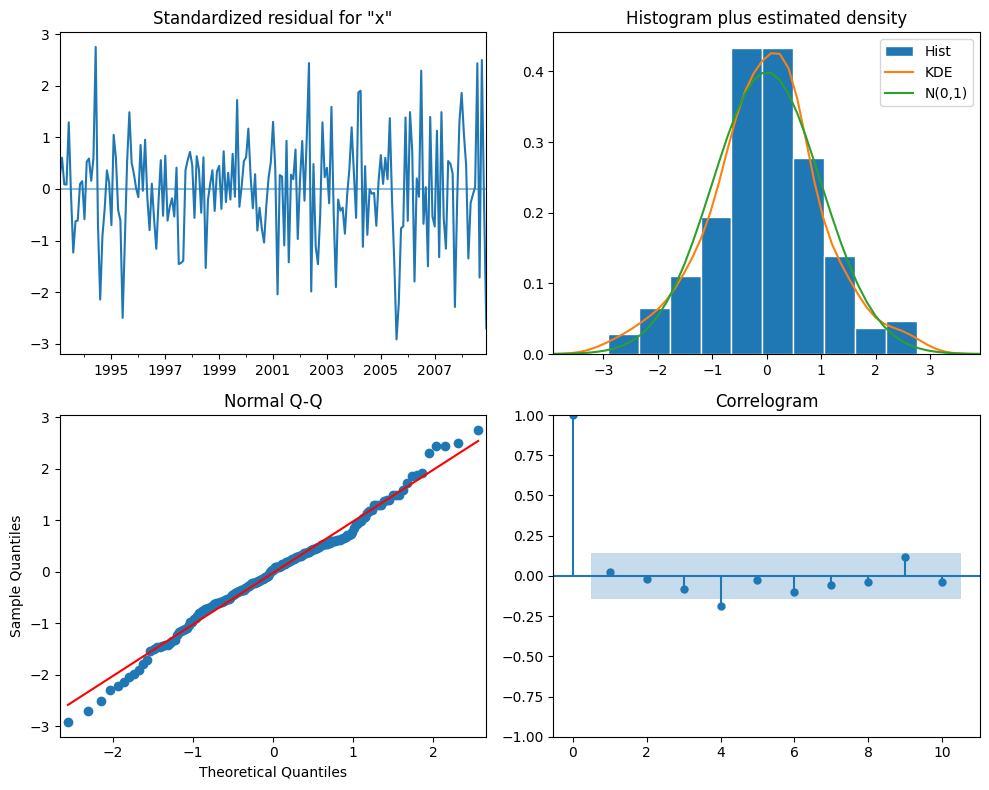

In [60]:
#모델 2안 적합
model = ARIMA(h02.x, order=(2,1,0), seasonal_order=(0,1,1,12))
fit = model.fit()
print(fit.summary())

#모델 2안 잔차 확인
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                                  x   No. Observations:                  204
Model:             ARIMA(2, 1, 3)x(0, 1, [1], 12)   Log Likelihood                 286.314
Date:                            Fri, 03 Jan 2025   AIC                           -558.629
Time:                                    13:52:33   BIC                           -535.863
Sample:                                01-01-1992   HQIC                          -549.408
                                     - 12-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2353      0.210     -5.889      0.000      -1.646      -0.824
ar.L2         -0.5680      0.222   

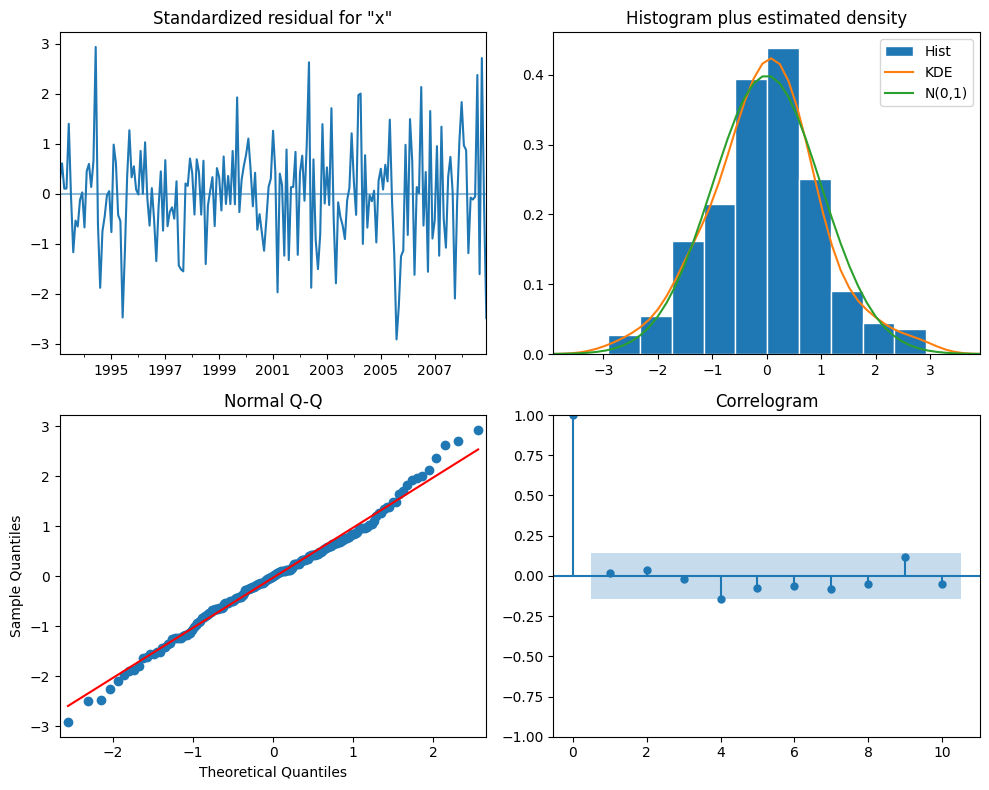

In [61]:
#모델 3안 적합
model = ARIMA(h02.x, order=(2,1,3), seasonal_order=(0,1,1,12))
fit = model.fit()
print(fit.summary())

#모델 3안 잔차 확인
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

                                       SARIMAX Results                                       
Dep. Variable:                                     x   No. Observations:                  204
Model:             ARIMA(3, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 289.609
Date:                               Fri, 03 Jan 2025   AIC                           -565.218
Time:                                       13:52:35   BIC                           -542.416
Sample:                                   01-01-1992   HQIC                          -555.983
                                        - 12-01-2008                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2438      0.150     -1.627      0.104      -0.537       0.050
ar.L2      

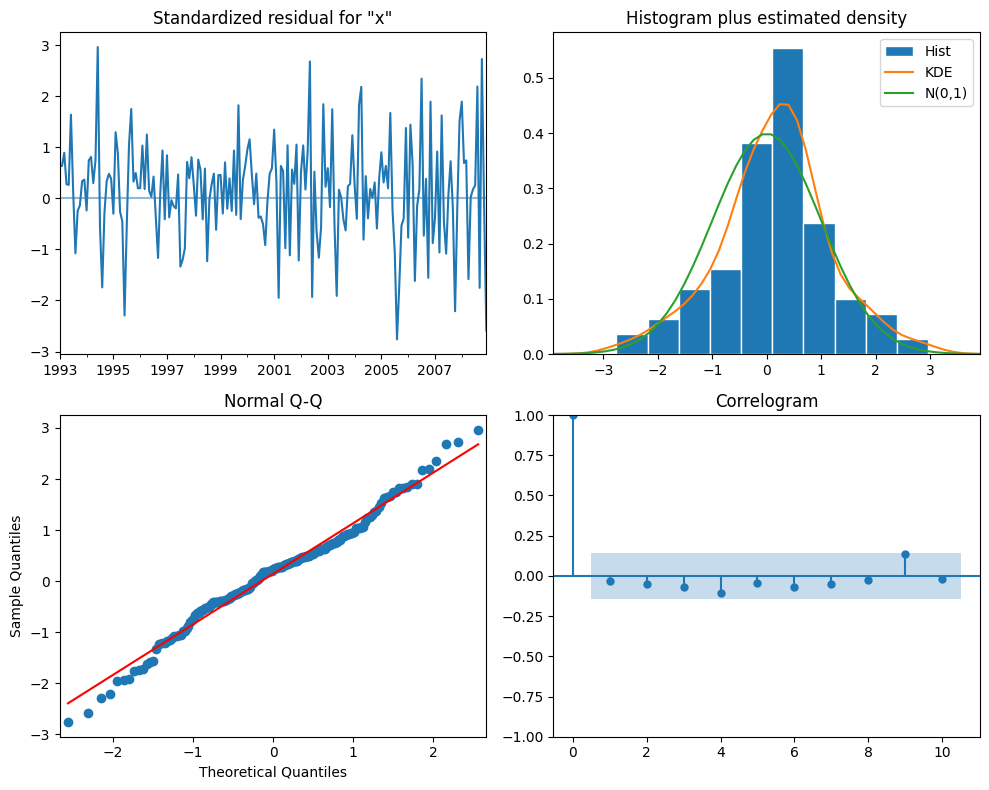

In [62]:
#모델 4안 적합
model = ARIMA(h02.x, order=(3,0,1), seasonal_order=(0,1,2,12))
fit = model.fit()
print(fit.summary())

#모델 4안 잔차 확인
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

#### 모델을 이용한 예측

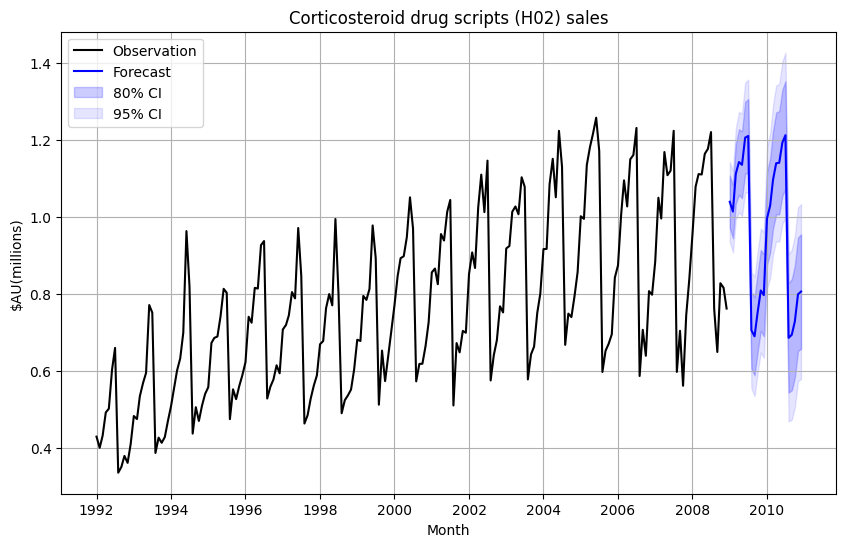

In [63]:
#SARIMA 예측값 구하기
forecast_result = fit.get_forecast(24)
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,1]

#예측 시각화
plt.figure(figsize=(10, 6))
plt.plot(h02.x, label='Observation', color='black')
plt.plot(forecast_mean, label='Forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
plt.xlabel('Month')
plt.ylabel('$AU(millions)')
plt.title('Corticosteroid drug scripts (H02) sales')
plt.grid(True)
plt.legend()
plt.show()

# 3.2.9 예측

### 이집트와 중앙 아프리카 공화국 수출량 예측

#### 모듈과 데이터 불러오기

In [64]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

#데이터 불러오기
global_economy = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/global_economy.csv')
global_economy['Year'] = pd.to_datetime(global_economy['Year'], format='%Y')
caf_exports = global_economy[global_economy['Code'] == 'CAF']
caf_exports.index = caf_exports['Year']
egypt_exports = global_economy[global_economy['Code'] == 'EGY']
egypt_exports.index = egypt_exports['Year']

#### 모델 적합

In [65]:
#중앙 아프리카 공화국 수출 모델 적합
caf_model = ARIMA(caf_exports['Exports'], order=(3,1,0))
caf_fit = caf_model.fit()

#이집트 수출 모델 적합
egp_model = ARIMA(egypt_exports['Exports'], order=(2,0,1))
egp_fit = egp_model.fit()

#### 모델을 이용한 예측

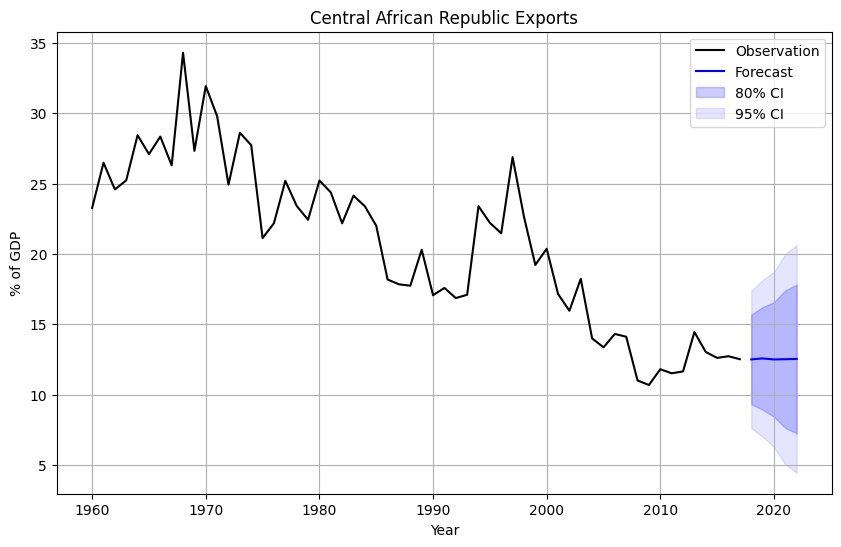

In [66]:
#중앙아프리카 공화국 예측값 구하기
forecast_result = caf_fit.get_forecast(5)
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,1]

#예측 시각화
plt.figure(figsize=(10, 6))
plt.plot(caf_exports['Exports'], label='Observation', color='black')
plt.plot(forecast_mean, label='Forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Central African Republic Exports')
plt.grid(True)
plt.legend()
plt.show()

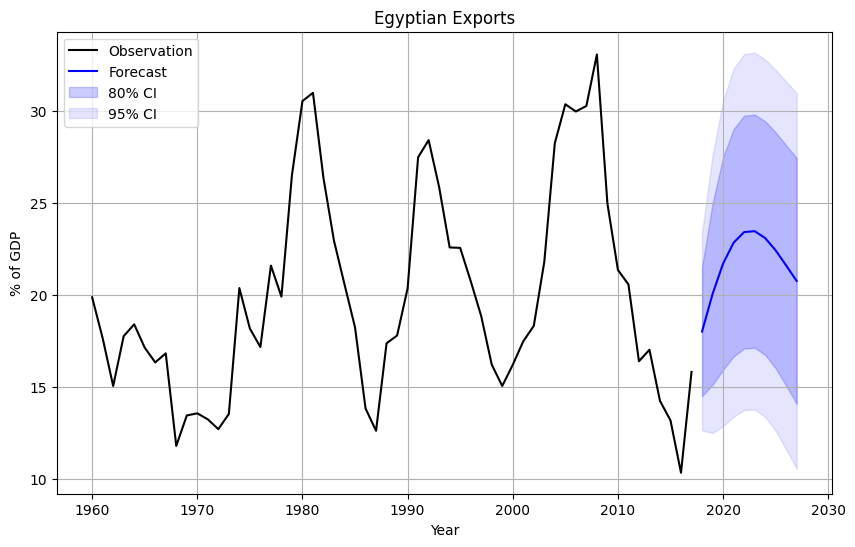

In [67]:
#이집트 예측값 구하기
forecast_result = egp_fit.get_forecast(10)
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,1]

#예측 시각화
plt.figure(figsize=(10, 6))
plt.plot(egypt_exports['Exports'], label='Observation', color='black')
plt.plot(forecast_mean, label='Forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Egyptian Exports')
plt.grid(True)
plt.legend()
plt.show()